In [ ]:
! pip install deepsnap

In [ ]:
! pip install torch-geometric

In [ ]:
!pip install torch-sparse

In [ ]:
!pip install torch-scatter

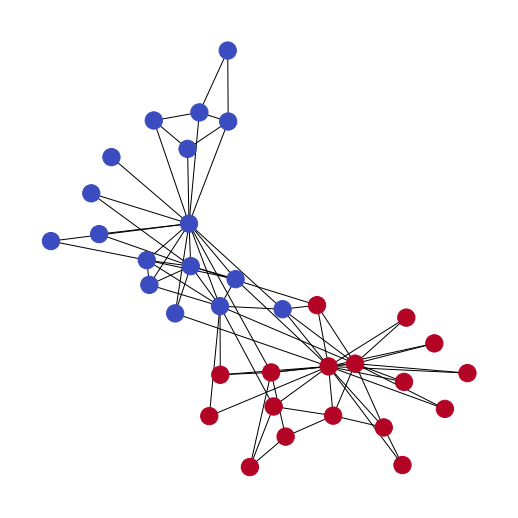

In [1]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        community_map[node[0]] = 0
    else:
        community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

(0, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_feature': tensor([1., 1., 1., 1., 1.]), 'node_label': 0})
(0, 1, {'weight': 4, 'edge_type': 'e0'})


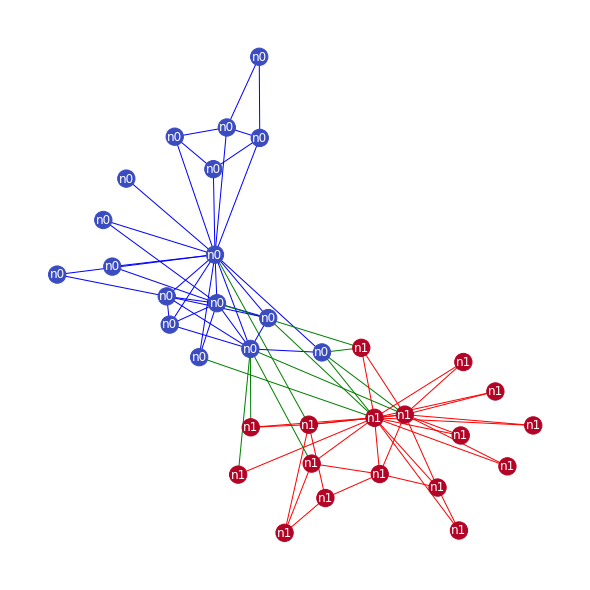

In [2]:
import torch

community_node = dict((k, "n" + str(v)) for k, v in community_map.items())
node_feature = dict(((node, torch.tensor([1, 1, 1, 1, 1.])) for node in G.nodes()))
node_label = dict((node[0], 0) if node[1]['club'] == 'Mr. Hi' else (node[0], 1) for node in G.nodes(data=True))
nx.classes.function.set_node_attributes(G, community_node, name='node_type')
nx.classes.function.set_node_attributes(G, node_feature, name='node_feature')
nx.classes.function.set_node_attributes(G, node_label, name='node_label')
community_edge = {}
edge_color = {}
for edge in G.edges():
    n1, n2 = edge
    community_edge[edge] = 'e' + str(community_map[n1]) if community_map[n1] == community_map[n2] else 'e2'
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
        edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
        edge_color[edge] = 'red'
    else:
        edge_color[edge] = 'green'
nx.classes.function.set_edge_attributes(G, community_edge, name='edge_type')
G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G, 'color').values()
for edge in G.edges(data=True):
    del edge[2]['color']
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

In [3]:
from deepsnap.hetero_graph import HeteroGraph

hetero = HeteroGraph(G_orig)
for edge in G_orig.edges(data=True):
    print(edge)
    break
print("Node types: {}".format(hetero.node_types))
print("Edge types: {}".format(hetero.edge_types))
print("Message types: {}".format(hetero.message_types))
for node_type in hetero.node_types:
    print("Node type {} has {} nodes".format(node_type, hetero.num_nodes(node_type)))
for message_type in hetero.message_types:
    print("Message type {} has {} edges".format(message_type, hetero.num_edges(message_type)))
print(hetero.node_feature)
print(hetero.node_label)

(0, 1, {'weight': 4, 'edge_type': 'e0'})
Node types: ['n0', 'n1']
Edge types: ['e1', 'e0', 'e2']
Message types: [('n0', 'e0', 'n0'), ('n0', 'e2', 'n1'), ('n1', 'e1', 'n1')]
Node type n0 has 17 nodes
Node type n1 has 17 nodes
Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges
{'n0': tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), 'n1': tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 

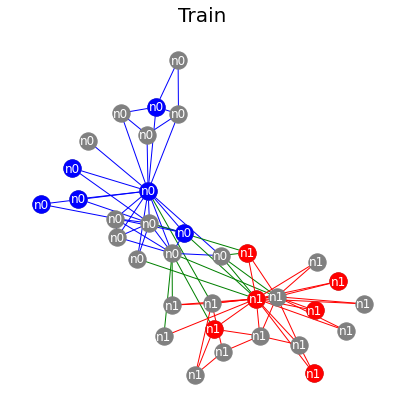

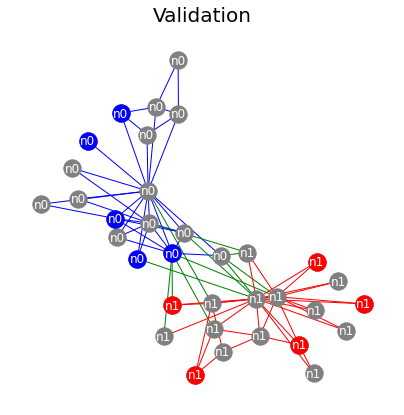

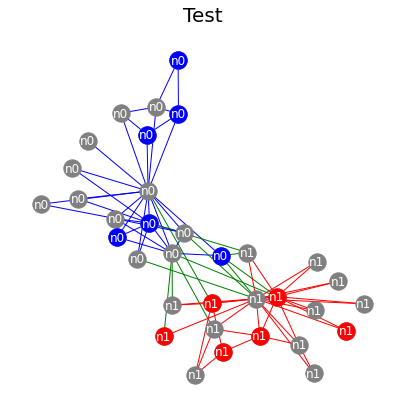

In [4]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hetero], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hetero._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hetero._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i], fontsize=20)
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

In [5]:
#!wget https://www.dropbox.com/s/gb6b3fixmaadltu/WN18.gpickle

## Creating data

In [1]:
import random
import torch
import networkx as nx
from deepsnap.hetero_graph import HeteroGraph

# Create an empty graph
G = nx.MultiDiGraph()

# Define the number of nodes for each type
num_advisors = 200  # Increase the number of advisors
num_products = 20   # Increase the number of products

# Create advisor nodes
for i in range(num_advisors):
    node_feature = torch.Tensor([random.random() for _ in range(10)])  # 10 features for advisors
    G.add_node(i, node_type='advisor', node_feature=node_feature,label = 'a')

# Create product nodes
for i in range(num_products):
    node_feature = torch.Tensor([random.random() for _ in range(5)])  # 5 features for products
    G.add_node(i + num_advisors, node_type='product', node_feature=node_feature,label = 'p')

# Connect some random advisors to product nodes with 'likes' edge type
for i in range(num_advisors):
    for j in range(num_products):
        if random.random() < 0.5:
            G.add_edge(i, j + num_advisors, edge_type='likes')
            G.add_edge( j + num_advisors,i, edge_type='liked_by')

# Create a HeteroGraph object
hetero = HeteroGraph(G)



In [2]:
hetero

HeteroGraph(G=[], edge_index=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[3954], edge_type=[], label=[], node_feature=[], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[220], node_type=[])

In [3]:
hetero.node_feature

{'advisor': tensor([[0.6723, 0.4709, 0.8588,  ..., 0.1805, 0.6440, 0.4962],
         [0.8326, 0.9068, 0.1967,  ..., 0.9717, 0.5100, 0.2878],
         [0.9436, 0.8747, 0.1238,  ..., 0.2258, 0.7793, 0.0021],
         ...,
         [0.4543, 0.2253, 0.6151,  ..., 0.7192, 0.5541, 0.5171],
         [0.6347, 0.2084, 0.2706,  ..., 0.2663, 0.0424, 0.9789],
         [0.3432, 0.7997, 0.2148,  ..., 0.5298, 0.9783, 0.9003]]),
 'product': tensor([[0.8413, 0.2387, 0.6201, 0.9741, 0.1591],
         [0.2294, 0.8038, 0.1983, 0.9019, 0.6477],
         [0.2239, 0.5131, 0.1544, 0.2193, 0.5389],
         [0.1064, 0.7113, 0.2731, 0.9527, 0.3874],
         [0.5214, 0.9387, 0.1329, 0.6964, 0.9978],
         [0.5322, 0.9120, 0.6239, 0.4735, 0.3390],
         [0.6385, 0.0650, 0.2190, 0.1857, 0.8420],
         [0.2712, 0.8739, 0.8191, 0.3795, 0.9554],
         [0.4959, 0.3189, 0.7042, 0.7864, 0.9561],
         [0.6236, 0.8265, 0.1910, 0.9586, 0.6707],
         [0.8885, 0.3552, 0.1577, 0.0923, 0.2923],
         [0

In [91]:
hetero.node_types

['advisor', 'product']

In [92]:
hetero.message_types

[('advisor', 'likes', 'product'), ('product', 'liked_by', 'advisor')]

In [93]:
hetero.edge_index

{('advisor',
  'likes',
  'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
         [  1,   3,   4,  ...,   8,  11,  19]]),
 ('product',
  'liked_by',
  'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
         [  2,   3,   7,  ..., 194, 195, 199]])}

In [94]:
hetero.edge_type

{('advisor', 'likes', 'product'): ['likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',
  'likes',

In [95]:
for message in hetero.edge_label_index:
    print(message)

('advisor', 'likes', 'product')
('product', 'liked_by', 'advisor')


In [96]:
hetero.node_label_index

{'advisor': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 17

In [97]:
hetero.node_feature

{'advisor': tensor([[0.1151, 0.3389, 0.1522,  ..., 0.6772, 0.2689, 0.0764],
         [0.6166, 0.3454, 0.2230,  ..., 0.4989, 0.6686, 0.6020],
         [0.8604, 0.3473, 0.2244,  ..., 0.9981, 0.5490, 0.6000],
         ...,
         [0.6246, 0.9480, 0.5899,  ..., 0.8118, 0.1226, 0.0623],
         [0.1445, 0.4028, 0.8992,  ..., 0.7808, 0.7846, 0.0298],
         [0.7049, 0.3811, 0.2413,  ..., 0.9522, 0.0122, 0.0238]]),
 'product': tensor([[0.8311, 0.9486, 0.8502, 0.5069, 0.4978],
         [0.6151, 0.7593, 0.7621, 0.7892, 0.0615],
         [0.9795, 0.3575, 0.8835, 0.1728, 0.8369],
         [0.8346, 0.1730, 0.5025, 0.8198, 0.3872],
         [0.1984, 0.6660, 0.8023, 0.6884, 0.8721],
         [0.7190, 0.2511, 0.8164, 0.7966, 0.6735],
         [0.0123, 0.9560, 0.4574, 0.2792, 0.8899],
         [0.7867, 0.2932, 0.9648, 0.7046, 0.7015],
         [0.7386, 0.7436, 0.7755, 0.7693, 0.8014],
         [0.3653, 0.1202, 0.8069, 0.0154, 0.6411],
         [0.3068, 0.1169, 0.9537, 0.0201, 0.3932],
         [0

In [68]:
hetero.message_types

[('advisor', 'likes', 'product'), ('product', 'liked_by', 'advisor')]

In [69]:
temp ={}
temp[('a','b')] = 2

In [70]:
temp

{('a', 'b'): 2}

In [71]:
#! pip install matplotlib networkx pygraphviz

In [109]:
! conda install -c conda-forge pygraphviz -y

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [108]:
! pip3 install pygraphviz

In [111]:
! conda install graphviz -y

Solving environment: ...working... done

## Package Plan ##



==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda






  environment location: C:\Users\somal\anaconda3\envs\graph_rec

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.12.12 |       haa95532_0         127 KB
    ------------------------------------------------------------
                                           Total:         127 KB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2023.11.~ --> pkgs/main::ca-certificates-2023.12.12-haa95532_0




ca-certificates-2023 | 127 KB    |            |   0% 
ca-certificates-2023 | 127 KB    | #2         |  13% 
ca-certificates-2023 | 127 KB    | ########## | 100% 
ca-certificates-2023 | 127 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [113]:
! conda install python-graphviz -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\somal\anaconda3\envs\graph_rec

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-graphviz-0.16       |     pyhd3eb1b0_1          20 KB
    ------------------------------------------------------------
                                           Total:          20 KB

The following NEW packages will be INSTALLED:

  python-graphviz    pkgs/main/noarch::python-graphviz-0.16-pyhd3eb1b0_1




python-graphviz-0.16 | 20 KB     |            |   0% 
python-graphviz-0.16 | 20 KB     | #######8   |  78% 
python-graphviz-0.16 | 20 KB     | ########## | 100% 
python-graphviz-0.16 | 20 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [115]:
! conda install pydot -y


Examining libxcb:   3%|2         | 2/77 [00:00<00:04, 18.29it/s] 


Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed


Examining cairo: 100%|##########| 77/77 [00:05<00:00, 19.35it/s]
                                                                

Determining conflicts:   0%|          | 0/77 [00:00<?, ?it/s]
Examining conflict for pydot python pip wheel pygraphviz setuptools python-graphviz:   0%|          | 0/77 [00:00<?, ?it/s]
Examining conflict for pydot openssl python pip wheel pygraphviz setuptools python-graphviz:   1%|1         | 1/77 [00:00<00:22,  3.37it/s]
Examining conflict for pydot openssl python pip wheel pygraphviz setuptools python-graphviz:   3%|2         | 2/77 [00:00<00:11,  6.74it/s]
Examining conflict for pydot pango pygraphviz python-graphviz graphviz:   3%|2         | 2/77 [00:00<00:11,  6.74it/s]                     
Examining conflict for pydot pango pygraphviz python-graphviz graphviz:   4%|3         | 3/77 [00:00<00:16,  4.61it/s]
Examining conflict for pydot gts pygraphviz python-graphviz graphviz:   4%|3         | 3/77 [00:00<00:16,  4.61it/s]  
Examining conflict for py

graphviz -> vc14_runtime[version='>=14.29.30139']
zstd -> vc[version='>=14.1,<15.0a0'] -> vc14_runtime[version='>=14.38.33130']
zstd -> vc14_runtime[version='>=14.29.30139']
python-graphviz -> python[version='>=3.12,<3.13.0a0'] -> vc14_runtime[version='>=14.29.30139']
libjpeg-turbo -> vc14_runtime[version='>=14.29.30139']
getopt-win32 -> vc14_runtime[version='>=14.29.30139']
libjpeg-turbo -> vc[version='>=14.1,<15.0a0'] -> vc14_runtime[version='>=14.38.33130']
gts -> vc14_runtime[version='>=14.29.30139']
libsqlite -> vc14_runtime[version='>=14.29.30139']
vc -> vc14_runtime[version='>=14.38.33130']
libglib -> vc[version='>=14.2,<15'] -> vc14_runtime[version='>=14.38.33130']
libgd -> vc14_runtime[version='>=14.29.30139']
xz -> vc[version='>=14.1,<15.0a0'] -> vc14_runtime[version='>=14.38.33130']
fribidi -> vc[version='>=14.1,<15.0a0'] -> vc14_runtime[version='>=14.38.33130']
libgd -> vc[version='>=14.1,<15.0a0'] -> vc14_runtime[version='>=14.38.33130']
openssl -> vc[version='>=14.1,<15.0

In [8]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# Define a function to visualize the graph
def visualize_graph(hetero):
    # Create a layout using graphviz_layout
    pos = graphviz_layout(hetero.G, prog="dot")

    # Draw the graph
    nx.draw(hetero.G, pos, with_labels=True, font_weight='bold', node_size=500, node_color='skyblue')
    plt.show()

# Visualize the HeteroGraph
visualize_graph(hetero)


ImportError: requires pygraphviz http://pygraphviz.github.io/

In [55]:
# import pickle

# # Reading the gpickle file
# with open('WN18.gpickle', 'rb') as f:
#     G = pickle.load(f)

for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_type': 'advisor', 'node_feature': tensor([0.7604, 0.0796, 0.2571, 0.6580, 0.1086, 0.5071, 0.8006, 0.7654, 0.0713,
        0.0505])})
(0, 100, {'edge_type': 'likes'})
Number of edges is 340
Number of nodes is 102


In [4]:
from typing import Dict

def generate_2convs_link_pred_layers(hete: HeteroGraph, conv: torch.nn.Module, hidden_size: int) -> Dict[str, torch.nn.Module]:
    """
    Generate two internal GNN layers for the link prediction task.

    Parameters:
        hete (HeteroGraph): The heterogeneous graph.
        conv (torch.nn.Module): The GNN convolutional layer to be used.
        hidden_size (int): The hidden size for the GNN layers.

    Returns:
        Tuple[Dict[str, torch.nn.Module], Dict[str, torch.nn.Module]]: Two dictionaries of GNN layers,
        one for the first convolutional layer (convs1) and the other for the second convolutional layer (convs2).
        The dictionaries are keyed by message types in the heterogeneous graph.

    Example:
        hete = HeteroGraph(G)  # Assume G is a heterogeneous graph
        conv = HeteroConv(...)  # Assume HeteroConv is the GNN convolutional layer
        hidden_size = 64
        convs1, convs2 = generate_2convs_link_pred_layers(hete, conv, hidden_size)
    """
    convs1 = {}
    convs2 = {}
    for message_type in hete.message_types:
        n_type = message_type[0]
        s_type = message_type[2]
        n_feat_dim = hete.num_node_features(n_type)
        s_feat_dim = hete.num_node_features(s_type)
        convs1[message_type] = conv(n_feat_dim, hidden_size, s_feat_dim)
        convs2[message_type] = conv(hidden_size, hidden_size, hidden_size)
    return convs1, convs2

In [5]:
# Import required libraries and modules
from pprint import pprint
from deepsnap.hetero_graph import HeteroGraph
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.hetero_gnn import HeteroSAGEConv
from torch.utils.data import DataLoader

# Convert the NetworkX graph 'G' into a DeepSNAP HeteroGraph
hetero = HeteroGraph(G)

# Set the hidden layer size for the GNN layers
hidden_size = 32

# Generate two HeteroSAGEConv layers for a link prediction task with the specified hidden size
conv1, conv2 = generate_2convs_link_pred_layers(hetero, HeteroSAGEConv, hidden_size)

# Print out the details of the first convolutional layer
pprint(conv1)

# Print out the details of the second convolutional layer
pprint(conv2)

# Create a GraphDataset for link prediction from the HeteroGraph, with negative sampling ratio set to 2.0
dataset = GraphDataset([hetero], task='link_pred', edge_negative_sampling_ratio=2.0)

# Split the dataset into training, validation, and testing datasets with ratios 0.8, 0.1, and 0.1, respectively, in a transductive setting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

# Create a DataLoader for the training set, using the Batch collate function, with batch size set to 1
train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=1)

# Create a DataLoader for the validation set, using the Batch collate function, with batch size set to 1
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=1)

# Create a DataLoader for the testing set, using the Batch collate function, with batch size set to 1
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=1)

# Group the DataLoaders into a dictionary for easy access during training and evaluation
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}


{('advisor', 'likes', 'product'): HeteroSAGEConv(neigh: 10, self: 5, out: 32),
 ('product', 'liked_by', 'advisor'): HeteroSAGEConv(neigh: 5, self: 10, out: 32)}
{('advisor', 'likes', 'product'): HeteroSAGEConv(neigh: 32, self: 32, out: 32),
 ('product', 'liked_by', 'advisor'): HeteroSAGEConv(neigh: 32, self: 32, out: 32)}


In [6]:
dataset_train

GraphDataset(1)

In [104]:
labels = nx.get_node_attributes(G, 'node_type')
labels

{0: 'advisor',
 1: 'advisor',
 2: 'advisor',
 3: 'advisor',
 4: 'advisor',
 5: 'advisor',
 6: 'advisor',
 7: 'advisor',
 8: 'advisor',
 9: 'advisor',
 10: 'advisor',
 11: 'advisor',
 12: 'advisor',
 13: 'advisor',
 14: 'advisor',
 15: 'advisor',
 16: 'advisor',
 17: 'advisor',
 18: 'advisor',
 19: 'advisor',
 20: 'advisor',
 21: 'advisor',
 22: 'advisor',
 23: 'advisor',
 24: 'advisor',
 25: 'advisor',
 26: 'advisor',
 27: 'advisor',
 28: 'advisor',
 29: 'advisor',
 30: 'advisor',
 31: 'advisor',
 32: 'advisor',
 33: 'advisor',
 34: 'advisor',
 35: 'advisor',
 36: 'advisor',
 37: 'advisor',
 38: 'advisor',
 39: 'advisor',
 40: 'advisor',
 41: 'advisor',
 42: 'advisor',
 43: 'advisor',
 44: 'advisor',
 45: 'advisor',
 46: 'advisor',
 47: 'advisor',
 48: 'advisor',
 49: 'advisor',
 50: 'advisor',
 51: 'advisor',
 52: 'advisor',
 53: 'advisor',
 54: 'advisor',
 55: 'advisor',
 56: 'advisor',
 57: 'advisor',
 58: 'advisor',
 59: 'advisor',
 60: 'advisor',
 61: 'advisor',
 62: 'advisor',
 6

NetworkXError: Node 34 has no position.

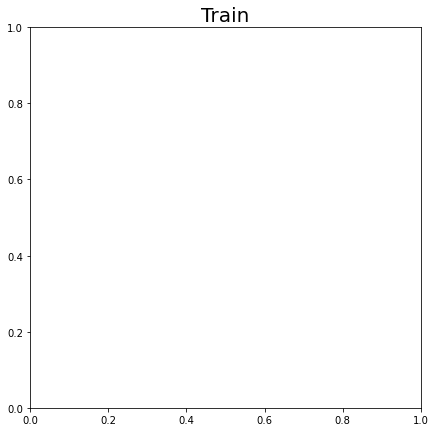

In [107]:
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    
    n0 = hetero._convert_to_graph_index(dataset[0].node_label_index['advisor'], 'advisor').tolist()
    n1 = hetero._convert_to_graph_index(dataset[0].node_label_index['product'], 'product').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i], fontsize=20)
    nx.draw(G, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G.subgraph(n0), pos=pos, node_color="lightblue", label='Advisor')
    nx.draw_networkx_nodes(G.subgraph(n1), pos=pos, node_color="lightcoral", label='Product')
    plt.legend()
    plt.show()


In [76]:
# Print information about the first batch in the training set
print("Training Set - First Batch:")
batch = next(iter(train_loader))
print("Edge Index:", batch.edge_index)
print("Node Features:", batch.node_feature)
print("Edge Label Index:", batch.edge_label_index)
#print("node types:", batch.node_types)

# Print information about the first batch in the validation set
print("\nValidation Set - First Batch:")
batch = next(iter(val_loader))
print("Edge Index:", batch.edge_index)
print("Node Features:", batch.node_feature)
print("Edge Label Index:", batch.edge_label_index)

# Print information about the first batch in the testing set
print("\nTesting Set - First Batch:")
batch = next(iter(test_loader))
print("Edge Index:", batch.edge_index)
print("Node Features:", batch.node_feature)
print("Edge Label Index:", batch.edge_label_index)

Training Set - First Batch:
Edge Index: {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 14,   6,  17,  ...,   1,  15,   7]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [ 71, 129,  78,  ..., 100,  45, 189]])}
Node Features: {'advisor': tensor([[0.7004, 0.1439, 0.9790,  ..., 0.5129, 0.2862, 0.7650],
        [0.5991, 0.9454, 0.1044,  ..., 0.4989, 0.7995, 0.5914],
        [0.7861, 0.7297, 0.2386,  ..., 0.5085, 0.7902, 0.3425],
        ...,
        [0.6086, 0.8345, 0.1938,  ..., 0.2440, 0.9306, 0.9926],
        [0.9205, 0.1743, 0.1941,  ..., 0.9163, 0.9284, 0.3351],
        [0.4723, 0.2667, 0.8253,  ..., 0.1825, 0.8188, 0.0091]]), 'product': tensor([[0.3125, 0.7974, 0.3053, 0.1352, 0.1851],
        [0.2925, 0.8103, 0.3403, 0.5016, 0.9213],
        [0.6889, 0.7763, 0.4863, 0.8478, 0.5209],
        [0.9455, 0.8077, 0.9469, 0.2673, 0.8202],
        [0.8053, 0.5519, 0.6176, 0.8374, 0.2920],
        [0.4143

In [77]:
batch.edge_label

{('advisor',
  'likes',
  'product'): tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
#dataset.edge_label

In [78]:
hetero

HeteroGraph(G=[], edge_index=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[3982], edge_type=[], negative_label_val=[1], node_feature=[], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[220], node_type=[], task=[])

In [79]:
hetero.node_types

['advisor', 'product']

In [39]:
batch = next(iter(train_loader))
x = batch.node_feature
x        

{'advisor': tensor([[0.1879, 0.3268, 0.8517,  ..., 0.4803, 0.7241, 0.8000],
         [0.6183, 0.4356, 0.2639,  ..., 0.2637, 0.4376, 0.1450],
         [0.6748, 0.7790, 0.4430,  ..., 0.6439, 0.4668, 0.9790],
         ...,
         [0.3173, 0.3875, 0.1098,  ..., 0.0898, 0.3540, 0.2442],
         [0.8946, 0.4403, 0.9026,  ..., 0.5043, 0.6800, 0.0631],
         [0.3076, 0.5448, 0.4251,  ..., 0.3499, 0.9548, 0.5638]]),
 'product': tensor([[0.3460, 0.3653, 0.9098, 0.7927, 0.9439],
         [0.8513, 0.7736, 0.5704, 0.3933, 0.3012],
         [0.7365, 0.8105, 0.2560, 0.3127, 0.2814],
         [0.5808, 0.5745, 0.5618, 0.1013, 0.8056],
         [0.1903, 0.6632, 0.2639, 0.5205, 0.3782],
         [0.4365, 0.5219, 0.1844, 0.7240, 0.2776],
         [0.5022, 0.8972, 0.6766, 0.8623, 0.7173],
         [0.6199, 0.2690, 0.7417, 0.3498, 0.0839],
         [0.9816, 0.0981, 0.2424, 0.2283, 0.9570],
         [0.7371, 0.4614, 0.3546, 0.7540, 0.5101],
         [0.7709, 0.9314, 0.0768, 0.4778, 0.5712],
         [0

In [65]:
edge_index = batch.edge_index
edge_index

{('advisor',
  'likes',
  'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
         [ 15,  16,  19,  ...,  11,   3,   9]]),
 ('firm',
  'belong',
  'advisor'): tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   2,
            2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
            2,   2,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   3,
            3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
            3,   3,   3,   3,   3,   3,   3,   3,   3,   4,   4,   4,   4,   4,
            4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
            4,   4,   4,   4,   

In [67]:
# Apply the first HeteroConv layer
#batch = next(iter(train_loader))
model = HeteroGNN(conv1, conv2, hetero, hidden_size)
x = model.convs1(x, edge_index)
x

{'product': tensor([[ 1.1808e+01, -2.5847e+00,  1.1111e+01,  1.1607e+01,  3.8313e+00,
          -1.1881e+01,  5.4136e+00,  7.4934e+00,  7.9060e+00,  1.6266e+00,
           1.5166e+01, -5.7696e+00,  3.7964e+00,  7.8416e-01,  8.3536e+00,
           3.2518e+00, -1.3436e+00, -7.8683e+00, -1.8335e+01,  1.3287e+00,
          -2.0266e+00, -1.2620e+01, -1.1166e+01, -8.0077e+00, -1.1144e+01,
          -5.7926e+00,  3.0490e+00,  1.4044e+00,  7.8680e+00,  5.3233e+00,
           1.2418e+01,  1.2375e+01],
         [ 8.4719e+00, -1.7526e+00,  9.1479e+00,  9.3720e+00,  3.3167e+00,
          -1.0068e+01,  3.8228e+00,  4.8920e+00,  7.1744e+00,  2.1458e+00,
           1.1488e+01, -4.5823e+00,  3.3361e+00,  2.3222e-01,  7.3598e+00,
           2.0500e+00, -7.7816e-01, -6.8458e+00, -1.5296e+01,  1.0727e-01,
          -1.9365e+00, -9.7727e+00, -9.5839e+00, -6.8037e+00, -8.4505e+00,
          -4.3708e+00,  2.1985e+00,  8.2148e-01,  5.9095e+00,  5.1437e+00,
           9.9567e+00,  1.0028e+01],
         [ 1.11

In [68]:
# Apply batch normalization followed by ReLU activation function for each node type
x = forward_op(x, model.bns1)
x

{'product': tensor([[ 1.4895e+00, -1.5929e+00,  8.3216e-01,  1.3237e+00,  1.1678e+00,
          -4.7272e-01,  5.9501e-01,  1.4842e+00,  5.3154e-01, -9.3662e-01,
           1.8621e+00, -1.0201e+00,  1.4041e-01,  5.0615e-01,  9.4867e-01,
           1.0823e+00, -9.0284e-02, -8.1923e-01, -1.2391e+00,  8.3416e-01,
          -2.1743e-01, -1.4517e+00, -9.5727e-01, -5.0746e-01, -1.8258e+00,
          -1.3538e+00,  1.6505e+00,  4.8545e-01,  1.3871e+00, -5.1805e-02,
           1.6263e+00,  1.0999e+00],
         [-1.8092e+00,  2.1409e-01, -1.6859e+00, -9.0285e-01,  1.9707e-01,
           1.2763e+00, -1.6044e+00, -1.6113e+00, -4.1099e-01,  1.2270e-01,
          -1.1648e+00,  1.1133e+00, -1.1634e+00, -5.1622e-01, -4.6140e-01,
          -5.1147e-01,  9.9899e-01,  6.4658e-01,  1.2248e+00, -1.2299e+00,
          -8.7678e-02,  1.3477e+00,  8.7091e-01,  1.2931e+00,  1.2348e+00,
           1.4836e+00, -3.4104e-01, -5.5456e-01, -1.2741e+00, -3.3124e-01,
          -1.0874e+00, -1.1780e+00],
         [ 8.74

In [69]:
x = forward_op(x, model.relus1)
x

{'product': tensor([[ 1.4895e+00, -1.5929e-02,  8.3216e-01,  1.3237e+00,  1.1678e+00,
          -4.7272e-03,  5.9501e-01,  1.4842e+00,  5.3154e-01, -9.3662e-03,
           1.8621e+00, -1.0201e-02,  1.4041e-01,  5.0615e-01,  9.4867e-01,
           1.0823e+00, -9.0284e-04, -8.1923e-03, -1.2391e-02,  8.3416e-01,
          -2.1743e-03, -1.4517e-02, -9.5727e-03, -5.0746e-03, -1.8258e-02,
          -1.3538e-02,  1.6505e+00,  4.8545e-01,  1.3871e+00, -5.1805e-04,
           1.6263e+00,  1.0999e+00],
         [-1.8092e-02,  2.1409e-01, -1.6859e-02, -9.0285e-03,  1.9707e-01,
           1.2763e+00, -1.6044e-02, -1.6113e-02, -4.1099e-03,  1.2270e-01,
          -1.1648e-02,  1.1133e+00, -1.1634e-02, -5.1622e-03, -4.6140e-03,
          -5.1147e-03,  9.9899e-01,  6.4658e-01,  1.2248e+00, -1.2299e-02,
          -8.7678e-04,  1.3477e+00,  8.7091e-01,  1.2931e+00,  1.2348e+00,
           1.4836e+00, -3.4104e-03, -5.5456e-03, -1.2741e-02, -3.3124e-03,
          -1.0874e-02, -1.1780e-02],
         [ 8.74

In [40]:
# Apply the second HeteroConv layer
x = model.convs2(x, edge_index)
x

KeyError: 'firm'

In [31]:
# Again apply batch normalization for each node type
x = forward_op(x, model.bns2)
x


{'product': tensor([[-6.2858e-01, -5.6695e-01, -6.3801e-01, -6.2126e-01, -5.7601e-01,
          -6.0504e-01, -6.1380e-01, -6.3701e-01, -6.2929e-01, -7.8592e-01,
          -7.2019e-01, -5.5010e-01, -7.3067e-01, -6.6982e-01,  1.3338e+00,
           1.2456e+00, -7.3454e-01, -3.9288e-01,  1.5334e-01, -2.9636e-01,
           5.9045e-01, -6.9012e-01, -6.9669e-01, -3.0466e-01,  9.9906e-01,
          -6.9747e-01, -4.1310e-01, -6.3147e-01, -6.9507e-01, -4.9145e-01,
          -7.2265e-01, -6.8535e-01],
         [-6.4840e-01, -7.4338e-01, -6.4741e-01, -6.4227e-01,  1.6815e+00,
          -6.0766e-01, -6.2956e-01, -4.1136e-01,  2.0642e+00,  2.1555e-01,
          -7.3527e-01,  2.6855e+00, -7.3642e-01,  2.8560e+00,  1.3089e+00,
          -6.7324e-01,  2.2934e+00,  2.1518e+00, -7.3113e-01, -7.8382e-01,
          -7.2809e-01, -7.0336e-01, -7.2467e-01,  2.0856e+00, -6.4554e-01,
          -7.1788e-01, -6.7168e-01,  2.9313e+00,  2.3232e+00, -6.3493e-01,
          -7.3982e-01,  2.6931e+00],
         [-6.28

In [70]:
batch.edge_label_index

{('advisor',
  'likes',
  'product'): tensor([[191, 195, 100,  ...,  32, 155, 150],
         [  5,  10,  15,  ...,  19,  18,   3]]),
 ('firm',
  'belong',
  'advisor'): tensor([[  0,   4,   4,  ...,   4,   3,   7],
         [ 90, 127, 180,  ...,  55,  70, 113]])}

In [71]:
batch

Batch(G=[1], batch=[230], edge_index=[], edge_label=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[1866], edge_type=[], negative_label_val=[1], node_feature=[], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[230], node_type=[])

In [72]:
hetero

HeteroGraph(G=[], edge_index=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[2333], edge_type=[], negative_label_val=[1], node_feature=[], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[230], node_type=[], task=[])

In [73]:
pred = {}

hetero = batch
for message_type in hetero.edge_label_index:
    # Select the node embeddings based on the edge indices
    print('inside_mtype',message_type)
    nodes_first = torch.index_select(x[message_type[0]], 0, hetero.edge_label_index[message_type][0,:].long())
    print('nodes_first',nodes_first)

    nodes_second = torch.index_select(x[message_type[2]], 0, hetero.edge_label_index[message_type][1,:].long())
    print('nodes_second',nodes_second)
    # Calculate the dot product of the node embeddings for each edge to get the prediction
    pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
            


inside_mtype ('advisor', 'likes', 'product')
nodes_first tensor([[-9.7992e-03, -4.4300e-03,  1.2334e+00,  ..., -8.5809e-03,
          1.0565e+00, -5.4875e-03],
        [-5.5446e-03, -6.0338e-03,  1.0014e+00,  ..., -1.4166e-02,
          3.5179e-01, -7.8668e-03],
        [-1.4326e-03, -9.5359e-03,  9.1885e-02,  ...,  5.1238e-01,
         -3.4073e-03,  1.4481e+00],
        ...,
        [ 8.8179e-03,  3.6737e-01, -2.5053e-03,  ..., -1.2271e-02,
         -6.0412e-03, -1.1552e-02],
        [ 3.7103e-01, -7.9653e-03,  2.6886e-01,  ...,  9.0401e-01,
          2.0540e-01, -4.9334e-03],
        [ 2.5383e-01,  9.3530e-01, -1.3585e-02,  ...,  1.6520e+00,
          1.1071e+00,  6.0755e-01]], grad_fn=<IndexSelectBackward0>)
nodes_second tensor([[-3.0884e-03,  1.5132e+00, -9.2671e-03,  ..., -2.1260e-04,
         -3.9336e-03, -2.3562e-03],
        [-8.5409e-03,  3.9240e-01, -8.3356e-03,  ...,  3.8081e-01,
          1.6095e-01, -1.5862e-03],
        [-1.0724e-02,  2.4751e-01, -4.2320e-03,  ..., -1.273

KeyError: 'firm'

In [121]:
nodes_first

tensor([[ 0.3078, -0.3148,  0.3007,  0.2881, -0.2789, -0.3064,  0.3322,  0.2957,
          0.2999, -0.3103, -0.2904,  0.3146,  0.3047, -0.3152,  0.3147, -0.3044,
         -0.2979, -0.3030, -0.3026,  0.3101, -0.2940,  0.3324,  0.3187, -0.3147,
          0.3027, -0.2901, -0.3081, -0.2924, -0.3193, -0.2928, -0.2968,  0.3037],
        [-0.5443,  0.5380, -0.5265, -0.5397,  0.5203,  0.5395, -0.5505, -0.5333,
         -0.5598,  0.5411,  0.5261, -0.5384, -0.5429,  0.5553, -0.5390,  0.5432,
          0.5450,  0.5324,  0.5441, -0.5378,  0.5222, -0.5534, -0.5469,  0.5524,
         -0.5414,  0.5419,  0.5211,  0.5350,  0.5487,  0.5283,  0.5387, -0.5308],
        [ 0.3078, -0.3148,  0.3007,  0.2881, -0.2789, -0.3064,  0.3322,  0.2957,
          0.2999, -0.3103, -0.2904,  0.3146,  0.3047, -0.3152,  0.3147, -0.3044,
         -0.2979, -0.3030, -0.3026,  0.3101, -0.2940,  0.3324,  0.3187, -0.3147,
          0.3027, -0.2901, -0.3081, -0.2924, -0.3193, -0.2928, -0.2968,  0.3037]],
       grad_fn=<IndexSel

In [122]:
nodes_first.shape

torch.Size([3, 32])

In [123]:
nodes_second

tensor([[ 1.7828, -1.7812,  1.7923,  1.7982, -1.8041, -1.7851,  1.7665,  1.8000,
          1.7825, -1.7819, -1.7938,  1.7801,  1.7849, -1.7773,  1.7753, -1.7829,
         -1.7880, -1.7923, -1.7853,  1.7808, -1.7940,  1.7586,  1.7807, -1.7769,
          1.7847, -1.7952, -1.7846, -1.7913, -1.7779, -1.7907, -1.7916,  1.7926],
        [ 1.7828, -1.7812,  1.7923,  1.7982, -1.8041, -1.7851,  1.7665,  1.8000,
          1.7825, -1.7819, -1.7938,  1.7801,  1.7849, -1.7773,  1.7753, -1.7829,
         -1.7880, -1.7923, -1.7853,  1.7808, -1.7940,  1.7586,  1.7807, -1.7769,
          1.7847, -1.7952, -1.7846, -1.7913, -1.7779, -1.7907, -1.7916,  1.7926],
        [-1.1160,  1.1146, -1.0938, -1.0865,  1.0777,  1.1107, -1.1400, -1.0704,
         -1.1220,  1.1169,  1.1010, -1.1182, -1.1129,  1.1234, -1.1332,  1.1194,
          1.1096,  1.0904,  1.1133, -1.1209,  1.0964, -1.1615, -1.1104,  1.1258,
         -1.1158,  1.0943,  1.1129,  1.1062,  1.1186,  1.1087,  1.0999, -1.0887]],
       grad_fn=<IndexSel

In [124]:
nodes_second.shape

torch.Size([3, 32])

In [125]:
mul = nodes_first * nodes_second
mul

tensor([[ 0.5487,  0.5607,  0.5390,  0.5181,  0.5032,  0.5469,  0.5868,  0.5323,
          0.5346,  0.5529,  0.5209,  0.5601,  0.5438,  0.5603,  0.5588,  0.5426,
          0.5327,  0.5432,  0.5403,  0.5522,  0.5274,  0.5845,  0.5675,  0.5593,
          0.5403,  0.5208,  0.5497,  0.5237,  0.5677,  0.5243,  0.5317,  0.5444],
        [-0.9703, -0.9583, -0.9436, -0.9705, -0.9388, -0.9630, -0.9725, -0.9600,
         -0.9979, -0.9642, -0.9437, -0.9584, -0.9690, -0.9870, -0.9570, -0.9685,
         -0.9745, -0.9542, -0.9714, -0.9577, -0.9368, -0.9732, -0.9739, -0.9816,
         -0.9662, -0.9729, -0.9299, -0.9584, -0.9755, -0.9461, -0.9652, -0.9516],
        [-0.3435, -0.3509, -0.3289, -0.3130, -0.3006, -0.3403, -0.3787, -0.3166,
         -0.3365, -0.3465, -0.3197, -0.3518, -0.3391, -0.3541, -0.3567, -0.3407,
         -0.3306, -0.3304, -0.3369, -0.3476, -0.3223, -0.3861, -0.3539, -0.3543,
         -0.3378, -0.3175, -0.3428, -0.3234, -0.3572, -0.3246, -0.3264, -0.3306]],
       grad_fn=<MulBackw

In [126]:
pred

{('advisor',
  'likes',
  'product'): tensor([-2.8935, -3.0221, -3.5048,  2.5037,  1.5013, -0.7052, -3.3358, -0.0492,
         -5.2959, -9.1982, -0.3982, -0.4318, -2.2052, -5.2895, -3.1466,  1.7142,
         -5.1461, -1.0298, -6.5781,  5.4490,  1.1561,  1.6628, -0.4505,  0.9559,
         -1.2512,  2.6769,  4.7195,  1.3143,  9.7878,  0.5792],
        grad_fn=<SumBackward1>),
 ('advisor',
  'same_title',
  'advisor'): tensor([ 21.3804, -29.0572,  25.3987,  53.5044,  20.0785,  15.8485,  22.2649,
          21.5939, -32.6502,  -6.7084,  44.0147,  12.4338, -14.2798,  -9.3493,
          25.4918,  22.8429, -25.9503, -14.1311,  -6.0808,  -6.8710, -25.9912,
          12.9423,  45.2107,  10.7842], grad_fn=<SumBackward1>),
 ('firm',
  'belong',
  'advisor'): tensor([-1.4830,  1.2522, -1.4043, -0.6914,  0.2056,  1.2760, -1.1928, -0.1556,
          1.4724, -0.1179, -1.7868, -0.7927,  1.1596, -1.2782, -0.1081,  1.4519,
          0.3287, -1.8881,  1.1892, -0.0899,  1.4718, -0.0509,  1.1045, -1.5350,
 

In [130]:
#batch = next(iter(train_loader))
#Loss calculations
# Initialize loss as 0
loss = 0
# For each edge type, calculate and sum up the loss
for key in pred:
    p = torch.sigmoid(pred[key])  # Apply sigmoid activation to the predictions
    print('key',key)
    print('p',p)
    print('actual_label',batch.edge_label[key])
    loss += model.loss_fn(p, batch.edge_label[key].type(pred[key].dtype))
    print('loss',loss)
    #loss = loss+loss# Compute and add BCEWithLogitsLoss

key ('advisor', 'likes', 'product')
p tensor([5.2475e-02, 4.6436e-02, 2.9176e-02, 9.2440e-01, 8.1777e-01, 3.3067e-01,
        3.4362e-02, 4.8770e-01, 4.9872e-03, 1.0122e-04, 4.0174e-01, 3.9369e-01,
        9.9281e-02, 5.0190e-03, 4.1227e-02, 8.4738e-01, 5.7883e-03, 2.6313e-01,
        1.3886e-03, 9.9572e-01, 7.6062e-01, 8.4062e-01, 3.8925e-01, 7.2231e-01,
        2.2250e-01, 9.3565e-01, 9.9116e-01, 7.8823e-01, 9.9994e-01, 6.4088e-01],
       grad_fn=<SigmoidBackward0>)
actual_label tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
loss tensor(0.8601, grad_fn=<AddBackward0>)
key ('advisor', 'same_title', 'advisor')
p tensor([1.0000e+00, 2.4023e-13, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 6.6100e-15, 1.2192e-03, 1.0000e+00, 1.0000e+00,
        6.2856e-07, 8.7020e-05, 1.0000e+00, 1.0000e+00, 5.3696e-12, 7.2933e-07,
        2.2811e-03, 1.0364e-03, 5.1540e-12, 1.0000e+00, 1.0000e+00, 9.9998e-01]

In [107]:
print(batch.edge_label)

{('advisor', 'likes', 'product'): tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), ('advisor', 'same_title', 'advisor'): tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('firm', 'belong', 'advisor'): tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('firm', 'same_segment', 'firm'): tensor([1, 0, 0])}


In [131]:
model.train()

HeteroGNN(
  (convs1): HeteroConv(
    (modules): ModuleList(
      (0): HeteroSAGEConv(neigh: 10, self: 7, out: 32)
      (1): HeteroSAGEConv(neigh: 10, self: 10, out: 32)
      (2): HeteroSAGEConv(neigh: 5, self: 10, out: 32)
      (3): HeteroSAGEConv(neigh: 5, self: 5, out: 32)
    )
  )
  (convs2): HeteroConv(
    (modules): ModuleList(
      (0-3): 4 x HeteroSAGEConv(neigh: 32, self: 32, out: 32)
    )
  )
  (loss_fn): BCEWithLogitsLoss()
  (bns1): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (firm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (product): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bns2): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (firm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (product): BatchNorm1d(32, eps=

In [7]:
# Import necessary modules from PyTorch and DeepSNAP
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepsnap.hetero_gnn import forward_op, HeteroConv

# Define the HeteroGNN class which is a subclass of torch.nn.Module
class HeteroGNN(torch.nn.Module):
    """
    Heterogeneous Graph Neural Network for link prediction.

    Args:
        conv1 (torch.nn.Module): First convolutional layer for the HeteroGNN.
        conv2 (torch.nn.Module): Second convolutional layer for the HeteroGNN.
        hetero (HeteroGraph): The heterogeneous graph.
        hidden_size (int): The hidden size for the GNN layers.

    Attributes:
        convs1 (HeteroConv): First HeteroConv layer with conv1 configurations.
        convs2 (HeteroConv): Second HeteroConv layer with conv2 configurations.
        loss_fn (torch.nn.BCEWithLogitsLoss): Binary Cross Entropy with Logits loss function.
        bns1 (nn.ModuleDict): Batch normalization layers for each node type in the first convolutional layer.
        bns2 (nn.ModuleDict): Batch normalization layers for each node type in the second convolutional layer.
        relus1 (nn.ModuleDict): ReLU activation layers for each node type in the first convolutional layer.
        relus2 (nn.ModuleDict): ReLU activation layers for each node type in the second convolutional layer.
        node_types (list): List of node types in the heterogeneous graph.
        edge_types (list): List of edge types in the heterogeneous graph.
    """
    # Initialize the HeteroGNN model with two convolution layers, the heterograph, and hidden size
    def __init__(self, conv1, conv2, hetero, hidden_size):
        super(HeteroGNN, self).__init__()

        # Initialize the first HeteroConv layer with conv1 configurations
        self.convs1 = HeteroConv(conv1)

        # Initialize the second HeteroConv layer with conv2 configurations
        self.convs2 = HeteroConv(conv2)

        # Define the loss function as Binary Cross Entropy with Logits
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

        # Create dictionaries to store batch normalization layers for each node type
        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()

        # Create dictionaries to store ReLU activation layers for each node type
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()

        # Get the node types and edge types from the heterograph
        self.node_types = hetero.node_types
        self.edge_types = hetero.edge_types
        
        # Initialize batch normalization and ReLU layers for each node type
        for node_type in self.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(hidden_size)
            self.bns2[node_type] = torch.nn.BatchNorm1d(hidden_size)
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()

    # Define the forward pass
    def forward(self, data):
        """
        Forward pass of the HeteroGNN for link prediction.

        Args:
            data (DeepSNAP Batch): The input data batch.

        Returns:
            dict: Predictions for each edge type in the heterogeneous graph.
        """
        # Extract node features and edge index from the input data
        x = data.node_feature
        edge_index = data.edge_index

        # Apply the first HeteroConv layer
        x = self.convs1(x, edge_index)
        print('printing_x_conv1',x)
        print('printing_edge_index_conv1',edge_index)

        # Apply batch normalization followed by ReLU activation function for each node type
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)

        # Apply the second HeteroConv layer
        x = self.convs2(x, edge_index)
        print('printing_x_conv2',x)

        # Again apply batch normalization for each node type
        x = forward_op(x, self.bns2)

        # Initialize an empty dictionary to store predictions
        pred = {}

        # Loop through each node type and edge type to compute predictions
       
        for message_type in data.edge_label_index:
            print('m_type',message_type)
            # Select the node embeddings based on the edge indices
            nodes_first = torch.index_select(x[message_type[0]], 0, data.edge_label_index[message_type][0,:].long())
            nodes_second = torch.index_select(x[message_type[2]], 0, data.edge_label_index[message_type][1,:].long())
            # Calculate the dot product of the node embeddings for each edge to get the prediction
            pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
        print('predictions',pred)
        return pred

    # Define the loss calculation
    def loss(self, pred, y):
        """
        Compute the Binary Cross Entropy loss between predicted and true labels.

        Args:
            pred (dict): Predictions for each edge type in the heterogeneous graph.
            y (dict): True labels for each edge type in the heterogeneous graph.

        Returns:
            torch.Tensor: The computed loss.
        """
        # Initialize loss as 0
        loss = 0
        # For each edge type, calculate and sum up the loss
        for key in pred:
            p = torch.sigmoid(pred[key])  # Apply sigmoid activation to the predictions
            loss += self.loss_fn(p, y[key].type(pred[key].dtype))  # Compute and add BCEWithLogitsLoss
        return loss


In [8]:
import numpy as np
import copy

# Function to train the model
def train(model, dataloaders, optimizer, args):
    """
    Train the HeteroGNN model.

    Args:
        model (HeteroGNN): The HeteroGNN model to be trained.
        dataloaders (dict): Dictionary of DataLoader objects for training, validation, and testing.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        args (dict): Additional training arguments, including the number of epochs and computing device.

    Returns:
        tuple: A tuple containing lists of training, validation, and testing accuracy metrics for each epoch.
    """
    # Initialize the best validation score and a copy of the model
    val_max = 0
    best_model = model

    # Lists to store accuracy metrics for each epoch
    t_accu = []
    v_accu = []
    e_accu = []

    # Loop over the number of epochs
    for epoch in range(1, args["epochs"] + 1):
        # Loop over each batch in the training dataloader
        for iter_i, batch in enumerate(dataloaders['train']):
            # Move the batch to the designated computing device
            batch.to(args["device"])

            # Set the model to training mode
            model.train()

            # Reset the gradients
            optimizer.zero_grad()

            # Forward pass: Compute predictions from the model
            pred = model(batch)

            # Compute the loss
            loss = model.loss(pred, batch.edge_label)

            # Backward pass: Compute gradient of the loss with respect to model parameters
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # Log and print the training status
            log = 'Epoch: {:03d}, Train loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            
            # Test the model performance after this training step
            accs = test(model, dataloaders, args)

            # Append the accuracy metrics to their respective lists
            t_accu.append(accs['train'])
            v_accu.append(accs['val'])
            e_accu.append(accs['test'])

            # Print the current metrics
            print(log.format(epoch, loss.item(), accs['train'], accs['val'], accs['test']))

            # Check if the current validation accuracy is the best so far
            # If so, update val_max and save a deep copy of the model
            if val_max < accs['val']:
                val_max = accs['val']
                best_model = copy.deepcopy(model)

    # Log and print the best performance over all epochs
    log = 'Best: Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    accs = test(best_model, dataloaders, args)
    print(log.format(accs['train'], accs['val'], accs['test']))

    # Return the accuracy metrics lists
    return t_accu, v_accu, e_accu

# Function to test the model's performance
def test(model, dataloaders, args):
    """
    Evaluate the performance of the HeteroGNN model on different datasets (train, val, test).

    Args:
        model (HeteroGNN): The trained HeteroGNN model.
        dataloaders (dict): Dictionary of DataLoader objects for training, validation, and testing.
        args (dict): Additional arguments, including the computing device.

    Returns:
        dict: A dictionary containing accuracy metrics for each dataset (train, val, test).
    """
    
    # Set the model to evaluation mode
    model.eval()

    # Dictionary to store accuracy metrics
    accs = {}

    # Loop over each mode (train, val, test) and its corresponding dataloader
    for mode, dataloader in dataloaders.items():
        # Initialize accuracy and count
        acc = 0
        num = 0

        # Loop over each batch in the dataloader
        for i, batch in enumerate(dataloader):
            # Move the batch to the designated computing device
            batch.to(args["device"])

            # Forward pass: Compute predictions from the model
            pred = model(batch)

            # Loop over each prediction and corresponding label
            for key in pred:
                # Apply sigmoid function and convert tensor to NumPy array
                p = torch.sigmoid(pred[key]).cpu().detach().numpy()

                # Initialize prediction labels as zeros
                pred_label = np.zeros_like(p, dtype=np.int64)

                # Assign predictions as 1 where the model's output is greater than 0.5
                pred_label[np.where(p > 0.5)[0]] = 1

                # Assign predictions as 0 where the model's output is less than or equal to 0.5
                pred_label[np.where(p <= 0.5)[0]] = 0

                # Count how many predictions match the actual labels
                acc += np.sum(pred_label == batch.edge_label[key].cpu().numpy())

                # Increment the total number of predictions
                num += len(pred_label)

        # Calculate the accuracy for the current mode
        accs[mode] = acc / num

    # Return the dictionary of accuracy metrics
    return accs



In [9]:
# Define a dictionary named `args` with hyperparameters and settings
args = {
    "device": "cpu",               # Device to run the model on ('cpu' or 'cuda')
    "epochs": 50,                  # Number of epochs for training
    "lr": 0.01,                    # Learning rate for optimizer
    "weight_decay": 1e-4           # Weight decay (L2 penalty) for regularization in optimizer
}

# Instantiate the HeteroGNN model with the previously created convolutional layers, heterograph, and hidden size
# Then, move the model to the computing device specified in `args` (in this case, CPU)
model = HeteroGNN(conv1, conv2, hetero, hidden_size).to(args["device"])

# Create an optimizer (Adam) for updating the model's weights.
# It uses the learning rate and weight decay values specified in `args`
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Train the model using the train function defined earlier, passing in the model, dataloaders, optimizer, and args
# This function will return training, validation, and test accuracies for each epoch, which are captured in t_accu, v_accu, and e_accu respectively
t_accu, v_accu, e_accu = train(model, dataloaders, optimizer, args)

printing_x_conv1 {'product': tensor([[ 4.0699e+00,  7.1866e+00, -1.0966e+01,  9.4697e-01, -8.2627e+00,
          1.5763e+01, -4.0577e-01, -2.8053e+00,  9.0523e+00, -1.3403e+01,
         -2.8259e+00,  1.2890e+01,  2.4744e+01,  1.0003e+01, -1.2582e+00,
         -9.2971e+00, -1.0799e+01, -6.4398e+00,  2.9856e+01, -1.0485e+01,
          1.8429e+01,  2.5181e+01, -5.8060e+00, -3.7173e-01, -1.3526e+01,
         -9.4385e+00,  8.9694e+00, -8.8200e+00, -1.2403e+01,  1.1088e+00,
         -6.3164e+00,  1.0486e+01],
        [ 3.5276e+00,  8.8540e+00, -9.3721e+00,  1.6566e+00, -8.4494e+00,
          1.3918e+01,  5.8731e-01, -2.5403e+00,  7.7512e+00, -1.2294e+01,
         -3.4522e+00,  1.1779e+01,  2.4080e+01,  9.0059e+00,  1.3958e-01,
         -9.3103e+00, -1.0098e+01, -7.3495e+00,  2.8030e+01, -8.2970e+00,
          1.7341e+01,  2.2435e+01, -5.5897e+00, -1.1094e+00, -1.1536e+01,
         -8.0135e+00,  6.7038e+00, -7.3616e+00, -1.1526e+01,  3.2633e-01,
         -5.6630e+00,  1.1167e+01],
        [ 3

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([ 2.5511, -3.3150, 24.4027,  ...,  2.2929, -0.0492,  5.1565],
       grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([ 12.9400,   8.0127,   4.3587,  ..., -21.7733,   3.1450,   1.7714],
       grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 7.3362e+00,  2.6306e+00,  1.4397e+00,  9.4366e+00, -2.4224e+00,
          1.2871e+01, -1.1246e+01,  1.4978e+00,  7.3989e+00, -1.7658e+01,
         -1.2933e+01,  1.0809e+01,  2.9391e+01,  1.3112e+01, -9.2369e+00,
         -2.3334e+01, -1.2307e+01, -7.3124e+00,  2.8471e+01, -1.6116e+01,
          8.9956e+00,  1.9915e+01,  6.7120e+00, -1.4555e+01, -1.2298e+01,
         -8.6233e+00, -2.6992e+00, -5.0389e+00, -3.6436e+00,  1.4369e+01,
          2.9153e+00, -6.1127e-01],
        [ 7.0149e+00,  4.5499e+00,  2.6516e+00,  9.3627e+00, -2.7303e+00,
          1.0609e+01, -1.0274e+01,  2.0424e+00

printing_x_conv1 {'product': tensor([[  7.8218,   5.9391,   8.9499,  10.9099,   0.1614,  11.7829, -12.5564,
          -2.7653,   7.2210, -18.0801, -17.3230,  10.2539,  30.2856,  14.9414,
         -12.9009, -27.3450, -12.2154, -12.2784,  26.0483, -18.8770,   3.6907,
          19.8326,   8.9242, -19.7917, -10.1221, -14.7334,  -7.3820,  -2.7719,
          -4.9101,  18.1992,   0.5984,   1.7472],
        [  7.6012,   7.6517,   9.9396,  10.5492,  -0.1602,   9.5583, -11.6814,
          -1.9154,   5.0367, -17.1068, -16.6116,   9.7475,  28.6013,  14.4914,
         -10.9006, -25.3489, -11.7907, -12.0746,  25.2409, -15.2496,   2.7488,
          16.9060,   7.5200, -19.3011,  -8.5990, -13.0758,  -9.6026,  -1.5064,
          -4.2646,  15.6033,   0.6212,   3.5588],
        [  7.1794,   6.9702,  10.2366,  10.0548,  -0.5696,  11.2211, -13.0630,
          -1.9740,   6.5141, -18.8246, -17.5313,  10.3509,  30.7398,  14.9788,
         -11.2498, -27.2483, -12.0250, -12.9207,  26.5532, -18.0094,   2.7893,
  

printing_x_conv1 {'product': tensor([[ 9.2445e+00,  9.1613e+00,  1.6409e+01,  1.2561e+01,  1.4629e+00,
          1.4660e+01, -1.4942e+01, -6.6745e+00,  4.2360e+00, -2.0267e+01,
         -2.2153e+01,  9.2026e+00,  3.3380e+01,  1.8568e+01, -1.6879e+01,
         -3.2771e+01, -1.3109e+01, -1.7029e+01,  2.5365e+01, -2.3025e+01,
          2.2682e+00,  2.3331e+01,  8.7996e+00, -2.5559e+01, -9.7801e+00,
         -2.1189e+01, -1.0837e+01,  2.2741e+00, -6.7108e+00,  2.3196e+01,
         -1.4236e+00,  6.3248e+00],
        [ 9.2037e+00,  1.0742e+01,  1.7481e+01,  1.1935e+01,  9.0859e-01,
          1.2785e+01, -1.4567e+01, -5.6787e+00,  2.0643e+00, -1.9626e+01,
         -2.1645e+01,  8.9472e+00,  3.1946e+01,  1.8497e+01, -1.5249e+01,
         -3.1177e+01, -1.3017e+01, -1.6869e+01,  2.5334e+01, -1.9484e+01,
          1.6597e+00,  2.0908e+01,  7.3705e+00, -2.5448e+01, -8.4121e+00,
         -1.9684e+01, -1.3423e+01,  3.8461e+00, -5.8972e+00,  2.0789e+01,
         -1.0426e+00,  8.1180e+00],
        [ 8

printing_x_conv2 {'product': tensor([[-1.4986e+01,  1.2016e+01, -2.0138e+01, -3.7057e+00, -7.0205e+00,
          1.6926e+01, -1.4962e+01, -3.7496e+00, -2.1604e+01, -4.7869e+01,
         -1.5394e+01,  2.6989e+01,  1.5291e+01,  9.1003e+00, -3.7726e+01,
         -3.3785e+01, -4.4305e+01, -2.7434e+01, -2.1111e+01,  1.0253e+01,
         -6.8446e+01, -1.9959e+01,  1.7230e+01,  3.2366e+01, -2.8435e+01,
         -2.6990e+01, -3.1189e+01,  1.9597e+01,  2.7525e+01, -3.2484e+01,
         -1.6366e+01,  2.9976e+01],
        [-1.8118e+01,  1.5940e+01, -2.0473e+01, -1.2577e+00, -7.7935e+00,
          1.4798e+01, -1.3901e+01, -4.4676e+00, -2.5325e+01, -4.9554e+01,
         -1.5466e+01,  2.9760e+01,  1.5035e+01,  1.1153e+01, -3.5898e+01,
         -3.2336e+01, -4.4923e+01, -2.4575e+01, -2.0265e+01,  1.3195e+01,
         -7.1261e+01, -2.1592e+01,  1.8156e+01,  3.4179e+01, -2.7187e+01,
         -2.7236e+01, -3.2073e+01,  1.8574e+01,  2.9964e+01, -3.2521e+01,
         -1.5068e+01,  3.3340e+01],
        [-1

Epoch: 006, Train loss: 1.5072, Train: 0.3333, Val: 0.3333, Test: 0.3333
printing_x_conv1 {'product': tensor([[ 14.7756,  11.0905,  23.8338,  16.0989,   7.9697,  14.6170, -17.5820,
         -12.4720,   6.0181, -20.6690, -25.0266,   7.6057,  29.6087,  22.1312,
         -20.7706, -35.4715,  -8.5580, -19.2754,  24.4974, -25.9098,  -3.4645,
          19.5521,   7.6605, -29.9426, -10.0760, -26.0320, -15.6434,   6.9692,
          -5.5456,  25.1076,  -7.1507,   9.0231],
        [ 14.6059,  12.7212,  24.4328,  15.1230,   7.6821,  12.1849, -16.5594,
         -10.9828,   3.2477, -19.6353, -23.6134,   7.5284,  27.5727,  21.9698,
         -18.3195, -32.5181,  -8.7327, -18.3187,  24.3082, -21.5535,  -4.1887,
          16.6622,   5.8532, -28.7899,  -8.3434, -23.5607, -17.7961,   7.9868,
          -5.0691,  21.6447,  -6.4824,  11.0437],
        [ 14.3564,  12.0515,  25.2253,  14.9450,   7.6667,  13.9400, -18.1811,
         -11.5437,   5.0554, -21.5542, -25.0488,   8.0154,  29.7738,  22.6129,
        

printing_x_conv1 {'product': tensor([[ 17.7750,  11.9563,  27.0700,  17.8524,  10.3656,  14.6121, -19.6962,
         -15.1228,   5.9916, -21.4336, -26.7627,   8.8244,  29.0558,  24.6189,
         -22.8952, -37.3217,  -5.6625, -20.0246,  26.1784, -27.7853,  -4.1960,
          18.4224,   8.2305, -32.3561, -11.0420, -28.0824, -18.2589,   7.7334,
          -4.1570,  26.1452,  -9.4111,   9.0167],
        [ 17.5989,  13.6169,  27.6150,  16.7113,  10.0926,  12.1422, -18.5610,
         -13.4800,   3.0831, -20.3587, -25.2000,   8.8581,  26.8778,  24.5546,
         -20.3168, -34.1672,  -6.1225, -18.9424,  26.1178, -23.2528,  -4.9820,
          15.6163,   6.2890, -31.0639,  -9.1477, -25.4011, -20.3737,   8.7348,
          -3.8016,  22.4820,  -8.5299,  11.2103],
        [ 17.4421,  12.9296,  28.4921,  16.6343,  10.1935,  13.8812, -20.2546,
         -14.1677,   5.0116, -22.3330, -26.7426,   9.3501,  29.1645,  25.2452,
         -20.8810, -36.9824,  -5.7478, -20.6652,  27.3310, -26.6525,  -5.4865,
  

printing_x_conv1 {'product': tensor([[ 21.3434,  13.4223,  32.8754,  20.3950,   8.8459,  19.5825, -22.3671,
         -19.4390,  -1.1041, -20.6099, -29.6193,  10.0229,  30.3392,  28.6502,
         -26.7378, -39.3686,  -5.1268, -21.9359,  27.7506, -30.0891,  -7.7231,
          19.7067,   5.0424, -36.0217, -10.3143, -32.3135, -21.7108,   8.7765,
          -0.9637,  28.4214, -14.3574,   9.2626],
        [ 21.2628,  15.0747,  33.2966,  18.9767,   8.7278,  16.9112, -21.0858,
         -17.5366,  -3.9439, -19.4666, -27.8609,  10.3149,  28.0548,  28.7344,
         -23.9307, -35.8995,  -5.7547, -20.5885,  27.9139, -25.2829,  -8.5071,
          16.9170,   2.9894, -34.4967,  -8.1806, -29.3313, -23.8480,   9.6933,
          -0.7754,  24.4318, -13.0593,  11.6476],
        [ 21.1418,  14.3712,  34.3446,  19.0505,   8.8590,  18.8222, -22.8561,
         -18.4386,  -2.1392, -21.5329, -29.5446,  10.7691,  30.4875,  29.4933,
         -24.5935, -39.0042,  -5.4197, -22.6088,  29.1610, -28.8967,  -9.2036,
  

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([3415.9272, 3541.6533, 3375.0898,  ..., 2194.1472, 3366.0532,
        2890.9312], grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([3831.6453, 2543.5073, 2005.3735,  ..., 4309.4810, 2283.3162,
        3066.6333], grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 23.0657,  15.0200,  35.5446,  21.0269,  10.1189,  20.6990, -22.7638,
         -21.1727,  -4.6181, -19.0032, -30.3810,  11.3473,  30.5632,  30.4727,
         -28.3387, -39.8653,  -8.7582, -23.3945,  28.1520, -30.8656,  -9.9443,
          18.7820,   4.0019, -37.4430,  -9.8264, -34.2044, -23.4323,  10.4665,
          -3.3413,  28.8963, -16.7350,   9.1664],
        [ 23.0006,  16.6008,  35.9034,  19.5534,   9.9368,  17.9528, -21.4559,
         -19.1664,  -7.4134, -17.8795, -28.5710,  11.7462,  28.2200,  30.6142,
         -25.4392, -36.2528,  -9.2261, -21.8884,  28.412

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-26.3707,  39.4619,  -6.8155,  -1.6125, -18.0003,  -1.4853, -20.3716,
         -16.7869, -34.3041, -34.7325,   2.9173,  16.2958,  20.4115,  12.1270,
         -40.4135, -39.7386,   2.4844, -17.8959, -17.8365,  25.3513, -40.3305,
         -23.9315,  14.8880,  27.2667, -27.8007, -16.5492,   4.8119, -12.0162,
          37.3686, -22.9206,   3.4216,  10.0437],
        [-33.0518,  41.8728,  -7.7621,   6.0937, -19.4508,  -4.8081, -17.2515,
         -22.8445, -39.0588, -32.5613,   2.6420,  19.5055,  25.2667,  17.1483,
         -34.6531, -35.2866,   8.4054, -14.1415, -15.8400,  29.6351, -36.8706,
         -28.3846,  16.1234,  25.9879, -21.8959, -18.5520,   9.0880, -16.5538,
     

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-27.3261,  44.4176,  -6.3114,  -2.4563, -17.6701,  -7.1000, -20.2714,
         -16.4581, -34.9568, -28.1478,   5.0878,  16.0097,  19.5590,  11.2205,
         -40.1470, -40.0127,   8.8864, -18.2772, -17.9322,  28.0061, -33.4074,
         -24.4577,  16.8206,  27.6351, -27.5273, -15.5098,  12.6614, -17.6684,
          32.3877, -23.6092,   5.8694,   5.0398],
        [-34.2903,  47.3538,  -6.8274,   5.7703, -19.5936, -10.7821, -16.7764,
         -22.8165, -40.3321, -25.7924,   4.7410,  19.9269,  24.6623,  16.3404,
         -34.4185, -35.4609,  15.1955, -14.1024, -15.2481,  32.4784, -30.2122,
         -29.0875,  18.0126,  26.3235, -21.5197, -17.7311,  17.0505, -22.6594,
     

printing_x_conv1 {'product': tensor([[ 28.1734,  20.4049,  44.7949,  22.4316,  17.4178,  22.7725, -24.9748,
         -27.1693, -14.4039, -16.0980, -34.7806,  14.0647,  36.8132,  36.2342,
         -32.8278, -42.9573, -18.6851, -28.3626,  27.6406, -35.3280, -12.1573,
          13.3554,  10.6198, -43.6723,  -9.6676, -40.8088, -28.5222,  10.2498,
          -8.6346,  32.4405, -23.7908,   5.6993],
        [ 28.5116,  22.0444,  45.9166,  20.9983,  16.7054,  20.6492, -24.4660,
         -25.4819, -17.3687, -15.0677, -33.6963,  14.9060,  34.5610,  37.2463,
         -30.7825, -40.0097, -18.8542, -27.1683,  28.8593, -30.6962, -13.1967,
          11.3700,   8.0898, -42.8702,  -7.0285, -38.2452, -31.4495,  11.5945,
          -7.9315,  28.7352, -22.0296,   8.6883],
        [ 28.8388,  21.6794,  47.4130,  21.5109,  17.4185,  22.4144, -26.4580,
         -26.9990, -16.0014, -17.4295, -35.7731,  15.6465,  37.2408,  38.5170,
         -31.7353, -43.5375, -19.3192, -29.9722,  30.4616, -34.6938, -14.3190,
  

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([2070.5845, 2845.9648, 1609.9927, 1398.5144, 1379.2893, 1922.3180,
        2813.7021, 1941.4169, 1563.5017, 1331.8447, 1428.3051, 1999.9497,
        1614.3518, 2878.8306, 1420.6249, 1607.0208, 1817.1423, 1312.8621,
        2303.8489, 2431.7827, 1150.3115, 1246.3651, 1605.1423, 2166.2778,
        1034.1068, 1679.1102,  840.2216, 2003.1072, 1334.0465, 1998.3022,
        1285.1152, 1193.1311, 1489.7920, 1941.9182, 1331.5240, 1368.7313,
        1279.7097, 1417.8181, 1020.8265, 2164.0781, 1938.8019, 1790.1968,
        1503.7131, 1839.8113, 1570.9800,  948.2867, 1197.1494, 1193.8071,
        1823.5706, 1415.6055, 1500.1176, 1075.7854, 1566.1910, 1499.6809,
        1636.8982, 1406.8406, 1814.0918, 1570.2083, 2093.7966, 2250.5852,
        2063.3884,  817.9522, 2370.2625, 1958.6855, 2045.0967, 2504.8716,
        1545.8237, 1195.3352, 1671.9432, 2699.4482,  437.05

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([1806.3108, 2485.3604, 1402.0261, 1276.3408, 1209.9509, 1665.8831,
        2508.7109, 1667.3917, 1342.5502, 1216.4336, 1206.5176, 1813.7623,
        1405.2097, 2470.7568, 1243.6038, 1413.3514, 1657.7693, 1134.7025,
        1971.5293, 2123.7217, 1031.1331, 1111.0927, 1409.8330, 1861.0264,
         904.2869, 1460.9958,  738.6369, 1684.1116, 1213.3517, 1817.4065,
        1116.6174, 1068.7905, 1362.7031, 1767.0751, 1218.5201, 1194.1865,
        1116.2405, 1254.3188,  855.9884, 1971.3191, 1772.5908, 1573.9678,
        1306.4889, 1691.3627, 1409.3728,  857.4070, 1024.2670, 1068.3065,
        1541.5494, 1222.2483, 1290.7769,  954.7263, 1350.6218, 1298.8042,
        1504.8557, 1293.8704, 1521.9774, 1344.8125, 1868.1606, 1982.2588,
        1888.3303,  711.2290, 2110.1567, 1679.1226, 1765.6074, 2297.3809,
        1404.7400, 1095.6753, 1474.1667, 2398.1929,  395.85

Epoch: 016, Train loss: 1.4263, Train: 0.3338, Val: 0.3350, Test: 0.3333
printing_x_conv1 {'product': tensor([[ 26.0745,  19.4485,  44.8062,  17.9662,  14.2509,  19.1542, -22.0481,
         -28.2414, -15.1297, -13.5396, -34.2865,  14.3795,  37.0774,  34.8153,
         -31.1346, -42.3596, -20.6105, -27.0903,  20.8544, -33.4286,  -9.9641,
           7.9434,   8.9064, -42.8745,  -7.2222, -39.6985, -26.2158,  12.2397,
         -13.8588,  30.4964, -25.3107,   4.1157],
        [ 26.0373,  20.6833,  44.9564,  16.6586,  13.6465,  16.4791, -20.7408,
         -25.8281, -18.0562, -12.3467, -32.2902,  15.1253,  34.2812,  35.0780,
         -28.1465, -38.4110, -20.5547, -25.1054,  21.8704, -28.0249, -11.2023,
           5.7152,   6.3978, -40.9143,  -4.3942, -36.1957, -28.3960,  12.8318,
         -13.0912,  26.1304, -23.1283,   7.4966],
        [ 26.0182,  20.2288,  46.2514,  16.5766,  14.5631,  18.1058, -22.3646,
         -27.1500, -16.4273, -14.6533, -34.1970,  15.6634,  36.9343,  35.9364,
        

printing_x_conv1 {'product': tensor([[ 26.5495,  19.4380,  45.5775,  17.2783,  13.0643,  18.7008, -22.1217,
         -29.1095, -15.0574, -13.3312, -34.7824,  16.0107,  37.7985,  35.1001,
         -31.6995, -43.5462, -21.2419, -27.1201,  19.0850, -33.5414,  -9.1344,
           8.6158,   8.8470, -43.5936,  -7.0243, -40.1964, -25.8792,  11.7759,
         -16.5649,  31.2086, -25.9501,   4.5886],
        [ 26.4912,  20.6948,  45.7244,  16.0033,  12.5107,  16.0430, -20.7183,
         -26.6434, -18.1535, -12.0738, -32.7556,  16.6638,  34.8813,  35.3529,
         -28.6718, -39.5733, -21.3065, -25.1588,  20.1692, -28.1015, -10.5383,
           6.3028,   6.3565, -41.6178,  -4.0936, -36.7391, -28.0771,  12.5288,
         -15.7302,  26.8133, -23.7340,   8.0984],
        [ 26.4814,  20.1981,  47.0395,  15.8977,  13.3870,  17.6873, -22.3844,
         -28.0114, -16.4669, -14.4104, -34.7025,  17.2792,  37.6033,  36.2214,
         -29.3018, -43.3583, -22.1384, -27.9112,  20.8041, -32.2831, -11.2586,
  

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-1.7574e+01,  1.2123e+01, -2.3083e+01, -3.9601e+00, -6.2342e+00,
          2.2526e+00, -1.2198e+01, -8.4153e+00, -1.9832e+01, -1.1711e+01,
          3.5738e+00, -8.7016e+00,  1.7914e+01,  4.1843e+00, -3.4569e+01,
         -2.2156e+01, -7.9113e-01, -3.0802e+01, -2.3046e+01,  7.3545e+00,
         -2.0390e+01, -2.4798e+00,  6.6723e+00,  9.4723e+00, -1.9089e+01,
         -1.2228e+01,  1.5510e+00, -2.5679e+00,  1.7007e+01, -2.2433e+01,
         -1.3962e+00, -5.1656e+00],
        [-2.4607e+01,  1.8887e+01, -2.2062e+01,  1.0398e+01, -9.7726e+00,
         -3.3630e+00, -7.3215e+00, -1.3870e+01, -2.6367e+01, -1.0793e+01,
          5.7033e-01,  9.5762e-01,  1.9818e+01,  1.2543e+01

predictions {('advisor', 'likes', 'product'): tensor([16.3176, 12.4702, 28.2588,  ..., -0.6676, -2.5655,  4.0554],
       grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([ 6.7255,  2.7387,  3.1386,  ...,  2.2547, -8.3968,  1.9754],
       grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 27.4748,  19.3062,  47.2299,  14.7139,  12.8805,  12.5247, -21.6715,
         -31.1168, -13.8176, -13.5873, -35.1570,  20.7966,  36.1703,  35.7120,
         -34.5315, -45.9635, -22.2840, -27.9836,  16.9998, -33.5543,  -9.0665,
           6.4380,  11.0408, -44.8083,  -3.9385, -42.1227, -25.4230,  13.7705,
         -21.5431,  29.9876, -28.0217,   4.7440],
        [ 27.4393,  20.6102,  47.3627,  13.7740,  12.2661,  10.0376, -20.0790,
         -28.5440, -17.4750, -12.1545, -33.0674,  21.1704,  32.9105,  35.9409,
         -31.2435, -41.9592, -22.6132, -26.0815,  18.1425, -27.9573, -10.9616,
           3.8380,   8.1734, -42.8645,  -0.7921, -38.7651, -27.7367,  14.5789,
     

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-25.2855,  30.2501, -34.1037, -18.4044, -19.3936,   7.4213, -33.0331,
         -29.0146, -15.2234, -27.4776,  16.8649, -15.9934,  32.4917,  20.2199,
         -62.4906, -62.9555,   6.6081, -48.3627, -40.3623,  17.8072, -15.0268,
         -11.9532,  27.5781,  17.2702, -19.5700, -18.0874,   7.4347, -24.1762,
          18.5522, -43.2585, -13.5253, -40.1769],
        [-35.3965,  37.6956, -33.9110,  -6.9760, -21.4811,   2.6497, -32.2996,
         -34.0457, -22.3183, -26.4456,  16.2076,  -7.5996,  35.9130,  26.1338,
         -57.2938, -58.2665,  13.7776, -42.9541, -35.2919,  25.1019, -12.8648,
         -17.7840,  26.9689,  17.8432, -13.5611, -22.0149,  11.2847, -32.5056,
     

predictions {('advisor', 'likes', 'product'): tensor([ -7.3665,  36.6525, 131.3356,  ...,  33.6440,  18.0971,  16.8623],
       grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([ 54.7739,   8.8406,  22.8950,  ...,  69.2825,  88.0967, 232.0153],
       grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 28.7608,  18.4942,  47.3670,  12.3772,  13.2906,   9.6137, -23.0555,
         -32.1430, -11.4712, -15.5567, -35.2905,  23.6629,  34.7730,  35.7422,
         -35.5449, -45.8894, -22.7501, -27.6130,  16.2399, -32.8607,  -8.3852,
           5.0355,  12.7978, -44.9012,  -2.8882, -42.4115, -24.8622,   8.4727,
         -22.8895,  29.5635, -28.5167,   3.7896],
        [ 28.7689,  19.8882,  47.5160,  11.8111,  12.5576,   7.3303, -21.2544,
         -29.5296, -15.5636, -13.8307, -33.1952,  23.9659,  31.2341,  36.0156,
         -32.1299, -41.9174, -23.1931, -25.8263,  17.5320, -27.2050, -10.4579,
           2.3495,   9.5887, -43.0700,   0.4270, -39.2004, -27.2901,   9

printing_x_conv1 {'product': tensor([[ 3.1841e+01,  1.9532e+01,  5.1072e+01,  1.2651e+01,  1.3616e+01,
          1.0002e+01, -2.3769e+01, -3.4957e+01, -1.1766e+01, -1.7386e+01,
         -3.7626e+01,  2.7137e+01,  3.7879e+01,  3.8308e+01, -3.8345e+01,
         -4.9225e+01, -2.4786e+01, -2.8919e+01,  1.7356e+01, -3.4736e+01,
         -7.4545e+00,  5.7772e+00,  1.3313e+01, -4.8107e+01, -2.0346e+00,
         -4.5492e+01, -2.6314e+01,  7.7794e+00, -2.5037e+01,  3.2000e+01,
         -3.1100e+01,  5.1897e+00],
        [ 3.2289e+01,  2.1246e+01,  5.2304e+01,  1.2099e+01,  1.2643e+01,
          8.3102e+00, -2.2896e+01, -3.3061e+01, -1.6340e+01, -1.5527e+01,
         -3.6481e+01,  2.7713e+01,  3.4538e+01,  3.9453e+01, -3.5928e+01,
         -4.6277e+01, -2.5495e+01, -2.7836e+01,  1.9110e+01, -2.9699e+01,
         -9.6673e+00,  3.1848e+00,  1.0040e+01, -4.7456e+01,  1.5917e+00,
         -4.3242e+01, -2.9685e+01,  9.8554e+00, -2.4181e+01,  2.8041e+01,
         -2.9038e+01,  9.1050e+00],
        [ 3

printing_x_conv1 {'product': tensor([[ 29.7988,  17.5083,  47.2942,  12.2502,  11.7868,   8.5075, -22.0279,
         -32.8808,  -9.8191, -16.2259, -34.7590,  25.5739,  34.7736,  35.6900,
         -36.0875, -45.4303, -21.6620, -26.1972,  17.1470, -31.4905,  -4.6532,
           4.9622,  10.8225, -44.5735,   0.4284, -41.8499, -25.4309,   8.3133,
         -22.1410,  29.4751, -28.9538,   4.8767],
        [ 29.8446,  18.9698,  47.4791,  11.8170,  11.0525,   6.4839, -20.2531,
         -30.2492, -14.2243, -14.3119, -32.7604,  25.8665,  31.0253,  36.0547,
         -32.6168, -41.5332, -22.2284, -24.5743,  18.6178, -25.8463,  -7.0570,
           2.3762,   7.5551, -42.8681,   3.7303, -38.8035, -27.8692,   9.7706,
         -21.2911,  24.9455, -26.6405,   8.6590],
        [ 29.8549,  18.2362,  48.9756,  11.3096,  11.9564,   8.2909, -21.9651,
         -31.7556, -11.9948, -17.0187, -34.7901,  26.8549,  34.2790,  36.9038,
         -33.6841, -45.3913, -23.1327, -27.4056,  19.3179, -30.1879,  -7.5299,
  

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([25.3251, 14.5803, 34.4979,  ..., -6.4579, -0.0556,  1.3850],
       grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([  8.3350,   1.9101,   2.7499,  ..., -12.2201, -17.0522, -11.0877],
       grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 31.3548,  16.2405,  46.4763,  14.6027,  11.4622,   5.1847, -22.9311,
         -33.8550,  -6.1129, -15.4196, -34.1256,  26.4445,  34.7168,  35.4713,
         -36.0724, -44.4804, -19.2111, -24.2008,  19.5971, -29.3712,   0.0680,
           3.8423,   9.9126, -44.3218,   4.7040, -40.7715, -27.0760,   5.2541,
         -20.3332,  29.1753, -29.2203,   2.6431],
        [ 31.4049,  17.7963,  46.7526,  13.9333,  10.6672,   3.4931, -21.1167,
         -31.1997, -10.9064, -13.4053, -32.2808,  26.7892,  30.8252,  35.9308,
         -32.6146, -40.6951, -19.9806, -22.8308,  21.0408, -23.7875,  -2.810

printing_x_conv1 {'product': tensor([[ 31.9071,  16.0895,  46.2613,  15.7775,  11.3890,   6.6590, -23.7962,
         -34.2039,  -4.1455, -14.4107, -34.2204,  26.6340,  34.6642,  35.2719,
         -36.0672, -44.0255, -18.0304, -23.2162,  20.5221, -28.2837,   2.4791,
           3.9412,   9.1193, -44.3645,   5.5709, -40.3776, -27.8506,   4.1388,
         -19.2385,  29.1905, -29.1467,   2.6587],
        [ 31.9902,  17.6654,  46.5546,  15.0073,  10.5778,   4.8998, -21.9409,
         -31.5426,  -9.1349, -12.3853, -32.4168,  26.9971,  30.6674,  35.7887,
         -32.6037, -40.2532, -18.8777, -21.9503,  21.9648, -22.7206,  -0.6315,
           1.5673,   5.9954, -42.7976,   8.7580, -37.6067, -30.2151,   6.0706,
         -18.4863,  24.5968, -26.8004,   6.6719],
        [ 32.0306,  16.7765,  48.0520,  14.6953,  11.5462,   6.7959, -23.6414,
         -33.0868,  -6.4505, -15.1779, -34.3346,  27.9888,  34.3313,  36.5430,
         -33.6713, -44.1193, -19.7205, -24.6913,  22.8644, -27.0877,  -0.7099,
  

printing_x_conv1 {'product': tensor([[ 3.2122e+01,  1.6895e+01,  4.6378e+01,  1.7111e+01,  1.1302e+01,
          7.9857e+00, -2.4516e+01, -3.4460e+01, -3.4412e+00, -1.3137e+01,
         -3.4397e+01,  2.6567e+01,  3.3769e+01,  3.5294e+01, -3.6094e+01,
         -4.3442e+01, -1.6669e+01, -2.2384e+01,  2.1391e+01, -2.6811e+01,
          4.7210e+00,  2.7776e+00,  6.7290e+00, -4.4366e+01,  5.8163e+00,
         -4.0038e+01, -2.8868e+01,  5.2214e+00, -1.7549e+01,  2.9038e+01,
         -2.9134e+01,  3.5815e+00],
        [ 3.2261e+01,  1.8440e+01,  4.6665e+01,  1.6296e+01,  1.0498e+01,
          6.1268e+00, -2.2608e+01, -3.1798e+01, -8.5628e+00, -1.1120e+01,
         -3.2610e+01,  2.6942e+01,  2.9680e+01,  3.5856e+01, -3.2607e+01,
         -3.9672e+01, -1.7589e+01, -2.1176e+01,  2.2834e+01, -2.1275e+01,
          1.4139e+00,  3.9989e-01,  3.6751e+00, -4.2798e+01,  9.0483e+00,
         -3.7324e+01, -3.1234e+01,  7.1453e+00, -1.6881e+01,  2.4400e+01,
         -2.6785e+01,  7.5821e+00],
        [ 3

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([ -61.9161,   31.1929,  -32.7912,  169.6185,  109.4626,  121.7587,
          64.9659,   53.3761,   77.2915,  -29.2441,   39.7052,   81.2694,
          42.8330,   14.4769,   45.9329,   32.2442,  -62.4165,   86.2522,
           0.7916,   25.3079,   85.3474,   -1.3905,   69.9885,   55.9054,
         116.2233,   66.0648,  -20.8589,   -0.5737,   56.1628,   85.3695,
          72.6418,  177.4826,   47.4094,   39.6067,   51.4619,  -28.2840,
         -77.1794,   -7.9262,   40.7117,    0.7141,   31.9750,   38.6598,
         -64.0946,   55.3930,   94.5776,   24.6451,   94.3239,  164.3546,
         143.2035,  -15.3690,   22.5877,   15.3795,   25.8738,   60.3093,
          57.7434,   39.2416,  144.5985,   73.7260,   49.9204,   61.8349,
         108.3982,   24.6644,   41.0953,  191.6722,   61.5875,  100.4308,
          81.7781,   73.8872,   57.0999,  124.7206,  138.49

printing_x_conv1 {'product': tensor([[ 34.9589,  20.3333,  49.9370,  18.9811,  13.4847,   9.8753, -25.9710,
         -37.3245,  -2.2275, -12.3593, -37.0053,  29.3320,  35.6719,  37.3748,
         -38.1094, -45.6964, -17.2575, -22.4408,  24.6567, -25.0027,   8.6602,
           1.4354,   4.9285, -47.6645,   5.6589, -42.4247, -31.8339,   6.4665,
         -17.3188,  31.0538, -31.3448,   8.3735],
        [ 35.7078,  22.1052,  51.2890,  18.1345,  12.3955,   8.3860, -25.0548,
         -35.4569,  -7.7786, -10.1320, -36.1456,  29.9478,  31.6139,  38.8222,
         -35.6311, -42.8460, -18.2389, -21.8355,  26.4841, -20.0124,   5.4148,
          -1.0955,   1.7177, -47.1955,   9.4878, -40.6396, -35.3275,   9.1291,
         -16.5857,  26.8501, -29.2404,  12.4501],
        [ 36.1058,  21.4193,  53.1278,  18.2766,  13.2396,  10.2733, -27.1643,
         -37.4625,  -4.7246, -13.1678, -38.3495,  31.4510,  35.5628,  39.9450,
         -37.0684, -46.6673, -18.7710, -24.7791,  28.0114, -24.2267,   5.4116,
  

printing_x_conv1 {'product': tensor([[ 3.2015e+01,  1.8845e+01,  4.5876e+01,  1.6677e+01,  1.2514e+01,
          1.0366e+01, -2.4876e+01, -3.4749e+01,  2.4266e-01, -1.1355e+01,
         -3.4686e+01,  2.6975e+01,  3.2596e+01,  3.4244e+01, -3.5300e+01,
         -4.1732e+01, -1.5256e+01, -2.0267e+01,  2.3887e+01, -2.1342e+01,
          8.4027e+00,  1.3680e+00,  5.0811e+00, -4.4425e+01,  5.4915e+00,
         -3.8900e+01, -2.9977e+01,  5.8230e+00, -1.4740e+01,  2.8362e+01,
         -2.8733e+01,  9.0514e+00],
        [ 3.2321e+01,  2.0331e+01,  4.6160e+01,  1.5836e+01,  1.1594e+01,
          8.2205e+00, -2.2921e+01, -3.2100e+01, -5.3256e+00, -9.2934e+00,
         -3.2874e+01,  2.7265e+01,  2.8105e+01,  3.4871e+01, -3.1694e+01,
         -3.7952e+01, -1.6113e+01, -1.9113e+01,  2.5206e+01, -1.5899e+01,
          4.7736e+00, -1.1369e+00,  1.9721e+00, -4.2816e+01,  8.9582e+00,
         -3.6289e+01, -3.2442e+01,  7.8307e+00, -1.4092e+01,  2.3627e+01,
         -2.6423e+01,  1.2930e+01],
        [ 3

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-2.6207e+01,  8.3597e+00, -2.4973e+01,  9.5659e-01, -1.7380e+01,
          1.5729e+01, -1.8035e+01, -1.4247e+01, -1.3134e+01,  2.5890e+00,
         -4.3168e+00, -4.9084e+00,  1.8412e+01,  1.3181e+01, -4.9017e+01,
         -3.3381e+01, -1.0305e+00, -4.2567e+01, -2.8377e+01,  6.4667e+00,
         -1.4526e+01, -7.2448e+00,  4.2135e+00,  6.0389e+00, -2.2868e+01,
         -9.9595e+00, -1.3503e+01,  9.9637e-01,  1.9236e+01, -3.2495e+01,
         -5.2066e+00, -9.8222e+00],
        [-3.0333e+01,  1.3854e+01, -2.3870e+01,  1.3691e+01, -2.2850e+01,
          9.8568e+00, -1.2469e+01, -1.4609e+01, -1.8806e+01,  1.5287e+00,
         -3.6151e+00,  6.1589e+00,  1.6202e+01,  2.0825e+01

printing_x_conv1 {'product': tensor([[ 30.8291,  19.2979,  44.7867,  14.9726,  13.9758,  12.5895, -25.5080,
         -34.7114,   4.6601, -12.5237, -35.4269,  26.3305,  32.7212,  32.9820,
         -34.2147, -40.4134, -16.2853, -19.1439,  25.6850, -16.0778,   8.6960,
           4.8237,   6.5394, -44.7574,   3.7957, -37.5302, -29.1477,   4.3220,
         -14.8821,  27.6912, -27.7907,  11.3542],
        [ 31.3973,  20.7677,  45.0664,  14.1755,  12.7267,  10.1218, -23.5774,
         -32.1040,  -1.3319, -10.2503, -33.5354,  26.6504,  27.7112,  33.6448,
         -30.4855, -36.5127, -16.6922, -17.7802,  26.8263, -10.7274,   4.9680,
           2.0621,   3.1965, -43.0582,   7.6430, -34.9711, -31.8312,   6.2422,
         -13.8390,  22.8583, -25.6025,  15.2327],
        [ 31.0897,  19.9565,  46.7505,  13.8511,  13.9935,  12.3481, -25.2817,
         -33.6646,   2.2541, -13.1777, -35.5116,  27.6839,  32.1017,  34.2821,
         -31.6336, -40.6125, -17.9284, -20.6667,  28.1757, -14.9763,   5.1640,
  

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-4.2354e+01,  4.6149e+00, -2.9977e+01,  1.4674e+01, -3.0456e+01,
          1.5006e+01, -1.5198e+01, -2.3260e+01, -2.0818e+01,  5.6490e-02,
          7.9021e-01,  7.1583e+00,  1.7202e+01,  3.1850e+01, -6.2336e+01,
         -4.6953e+01, -6.1689e+00, -5.0061e+01, -2.9025e+01,  8.1430e+00,
         -1.5361e+01, -2.0701e+01,  8.5200e+00, -2.6074e-01, -2.7332e+01,
         -1.4156e+01, -2.7296e+01,  2.6156e+00,  2.7952e+01, -4.7084e+01,
         -1.5397e+00, -1.1616e+01],
        [-4.6782e+01,  9.3733e+00, -2.9760e+01,  2.7438e+01, -3.5125e+01,
          9.0028e+00, -1.0505e+01, -2.3699e+01, -2.8093e+01, -3.1189e-01,
          2.1982e+00,  2.0346e+01,  1.3735e+01,  3.9980e+01

predictions {('advisor', 'likes', 'product'): tensor([164.2952, 104.7780, 241.5803,  ...,  59.2823,  39.7468,  24.6797],
       grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([127.5389,   2.3694,  72.6227,  ..., 112.2147,  64.3286,  41.9858],
       grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 30.3261,  19.7235,  44.3838,  16.4984,  15.6629,  13.2816, -26.7330,
         -35.0401,   7.5468, -13.9415, -36.0625,  25.4192,  32.4096,  33.0360,
         -33.6028, -39.5146, -16.2402, -19.3439,  25.7986, -13.2592,   8.4185,
           4.0846,   7.9552, -45.1335,   3.5683, -36.8465, -29.0766,   3.2499,
         -13.8573,  27.6223, -27.5481,  10.0198],
        [ 31.0380,  21.1746,  44.6492,  15.5966,  14.2387,  10.5837, -24.7309,
         -32.4190,   1.3608, -11.4854, -34.0759,  25.7701,  27.0463,  33.6887,
         -29.8150, -35.5222, -16.2947, -17.8446,  26.9561,  -7.9987,   4.5084,
           1.3589,   4.5671, -43.3467,   7.5332, -34.3271, -31.8458,   5

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([ 53.9352, 105.5846, 153.7741, 242.8286, 318.4317, 103.2596, 138.3706,
        150.4854, 233.6228, 130.2752,  86.1622, 137.0061, 104.1651,  49.6567,
         94.0586, 264.9442, 186.6199,  94.0520,  93.3096,  74.9992, 269.1495,
        103.8096, 265.0859,  68.3501, 132.9069,  89.9948, 141.2253, 103.9205,
        135.4092, 149.6180, 110.4996, 209.4359, 114.4003,  94.0615,  90.7191,
        119.5788,  44.7450,  98.6631,  79.8121,  88.7381,  66.0334,  57.2713,
        110.0351, 192.2807, 148.4149, 133.8753, 283.7829, 182.2100, 136.5473,
        172.3648, 105.1202,  72.3292,  72.0462, 115.9139, 113.2247, 140.0693,
        196.6839, 161.6768, 104.5300,  54.9646, 123.4321,  97.2715, 118.8121,
        265.2100, 117.5957, 229.4595, 178.8151, 226.1703, 111.7668,  84.7068,
        272.9254,  80.8693, 156.6081, 188.2386, 194.8955, 132.9959,  67.2711,
        202.752

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ..., 134,  14,  83]])}
printing_x_conv2 {'product': tensor([[-38.5553,  -4.2959, -41.0674,  24.7424, -38.0545,  16.5701,  -4.9757,
         -45.7482, -24.4177, -24.5445,  12.7545,   9.5755,  36.3442,  46.5995,
         -64.4958, -54.4229,  -4.5905, -52.4727, -36.9708,  10.2250, -36.8413,
         -32.3114,  26.2642,  -2.0689, -25.8528, -18.0110, -48.1867,   9.0498,
          39.1848, -49.5635,   0.7441,   6.5241],
        [-40.8895,   1.2702, -42.3028,  34.3266, -48.4699,  10.8172,   0.7388,
         -48.9687, -32.3090, -31.9182,  21.4143,  20.8171,  32.8264,  55.9115,
         -60.4734, -48.4812,  -8.1233, -45.3841, -33.0294,  19.6396, -37.8187,
         -35.7005,  27.6849,  -1.4748, -19.1960, -22.2993, -58.8478,   0.0764,
     

printing_x_conv2 {'product': tensor([[-37.2734,  -5.9111, -41.4787,  27.4855, -35.1980,  15.8514,  -3.2619,
         -49.1710, -25.3674, -25.7749,  12.0325,   9.3521,  40.8813,  47.6915,
         -62.7803, -52.5277,  -0.1115, -50.3803, -37.7584,  10.8219, -39.9368,
         -34.2131,  29.0671,  -3.3228, -23.8787, -14.7812, -47.6878,  13.4980,
          39.2361, -46.7323,   1.1043,  11.3410],
        [-38.9098,  -0.5884, -42.7903,  37.1156, -45.6944,   9.9034,   3.1611,
         -52.0200, -32.9451, -33.3166,  20.9030,  21.0432,  37.3051,  56.6482,
         -58.5034, -46.0187,  -4.1247, -43.2532, -33.5930,  20.0008, -40.9267,
         -37.5367,  30.1337,  -2.8968, -17.1190, -19.1014, -58.3257,   5.1791,
          36.9066, -47.6128,   0.9016,  17.4972],
        [-40.7112, -10.9995, -43.7415,  31.4537, -40.9891,  18.3542,  -2.7656,
         -40.2906, -20.9284, -17.0931,  15.9200,  20.5686,  32.8523,  44.7436,
         -64.4549, -48.9473, -12.9907, -54.7484, -32.3872,  12.3434, -28.4674,
  

Epoch: 040, Train loss: 1.3441, Train: 0.3333, Val: 0.3333, Test: 0.3333
printing_x_conv1 {'product': tensor([[ 30.2899,  21.2541,  44.8355,  19.5837,  18.4501,  12.3236, -27.9688,
         -35.3540,   6.0218, -18.2756, -37.1059,  24.4554,  33.1339,  34.2906,
         -32.3318, -39.0045, -17.2483, -19.9229,  23.8454,  -7.6633,   6.7139,
           6.6373,   7.9573, -45.4242,   6.8599, -35.4444, -29.4226,   5.9113,
         -13.4862,  26.7479, -26.5344,   9.4147],
        [ 31.2144,  22.6373,  45.0487,  18.6657,  16.8090,   9.4385, -25.8887,
         -32.7099,  -0.2413, -15.3378, -34.9805,  24.9026,  27.3626,  34.8697,
         -28.5525, -34.7965, -16.8274, -18.1903,  25.3387,  -2.6893,   2.6684,
           3.7635,   4.7080, -43.6076,  10.7210, -32.9906, -32.2936,   7.4181,
         -12.1960,  21.7811, -24.5492,  13.4947],
        [ 30.6868,  21.9746,  46.8978,  18.5487,  18.4504,  11.6265, -27.6734,
         -34.3450,   3.7268, -18.6411, -37.1276,  25.8766,  32.0564,  35.5852,
        

printing_x_conv1 {'product': tensor([[ 3.0543e+01,  2.1523e+01,  4.5061e+01,  2.0799e+01,  1.8754e+01,
          1.1731e+01, -2.7981e+01, -3.5431e+01,  4.4798e+00, -1.9097e+01,
         -3.7324e+01,  2.4288e+01,  3.3038e+01,  3.4828e+01, -3.1943e+01,
         -3.8835e+01, -1.7156e+01, -1.9960e+01,  2.4021e+01, -6.6269e+00,
          6.6998e+00,  7.0624e+00,  6.9499e+00, -4.5419e+01,  8.3010e+00,
         -3.4990e+01, -2.9821e+01,  7.2177e+00, -1.3116e+01,  2.6032e+01,
         -2.6363e+01,  9.3295e+00],
        [ 3.1485e+01,  2.2892e+01,  4.5256e+01,  1.9908e+01,  1.7133e+01,
          8.7913e+00, -2.5901e+01, -3.2787e+01, -1.7431e+00, -1.6076e+01,
         -3.5165e+01,  2.4765e+01,  2.7241e+01,  3.5405e+01, -2.8178e+01,
         -3.4559e+01, -1.6660e+01, -1.8193e+01,  2.5574e+01, -1.7180e+00,
          2.6139e+00,  4.1152e+00,  3.7699e+00, -4.3629e+01,  1.2098e+01,
         -3.2554e+01, -3.2684e+01,  8.6007e+00, -1.1774e+01,  2.1056e+01,
         -2.4405e+01,  1.3451e+01],
        [ 3

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-24.7507, -12.6355, -39.1484,   5.8701, -32.7463,  30.2486,  -9.7342,
         -28.4755, -14.0811,  -9.8412,   8.9443,   3.1377,  25.4786,  33.5634,
         -64.5367, -44.9607, -14.9700, -55.1329, -49.6488,  -1.9440, -24.1687,
         -14.5656,  11.4483,  -4.3788, -30.7852,  -7.6189, -40.5355,  10.7919,
          21.0303, -49.2874, -21.0010,   6.8141],
        [-26.6774,  -9.2717, -40.2925,  17.1102, -35.7439,  24.5136,  -5.7800,
         -26.0565, -19.6420,  -7.7460,   8.8095,  18.3510,  19.6860,  39.5512,
         -59.3711, -35.6193, -17.2361, -46.5675, -37.7904,   7.5163, -22.5317,
         -17.6675,   6.8577,  -1.8577, -24.1592, -13.6305, -49.2529,   8.8125,
     

printing_x_conv2 {'product': tensor([[-2.2990e+01, -1.5517e+01, -4.2837e+01,  5.8287e+00, -3.3812e+01,
          3.3273e+01, -8.8893e+00, -3.1985e+01, -1.4054e+01, -1.3330e+01,
          1.0931e+01,  2.6671e+00,  2.8975e+01,  3.7189e+01, -6.6454e+01,
         -4.7047e+01, -1.6383e+01, -5.8396e+01, -5.3946e+01, -3.5371e+00,
         -2.6634e+01, -1.4847e+01,  1.3873e+01, -5.0866e+00, -3.0793e+01,
         -7.8760e+00, -4.5369e+01,  1.2383e+01,  2.0026e+01, -4.9941e+01,
         -2.3790e+01,  9.2600e+00],
        [-2.4703e+01, -1.2343e+01, -4.3623e+01,  1.6878e+01, -3.6911e+01,
          2.7375e+01, -4.9167e+00, -2.9156e+01, -1.9125e+01, -1.0166e+01,
          1.0537e+01,  1.7987e+01,  2.3123e+01,  4.2463e+01, -6.1709e+01,
         -3.7594e+01, -1.8964e+01, -5.0184e+01, -4.2189e+01,  5.6812e+00,
         -2.4752e+01, -1.7009e+01,  9.0021e+00, -2.5225e+00, -2.4267e+01,
         -1.3897e+01, -5.2994e+01,  1.1212e+01,  1.3318e+01, -4.7401e+01,
         -2.2812e+01,  1.5378e+01],
        [-2

printing_x_conv2 {'product': tensor([[-2.1288e+01, -2.2436e+01, -5.8274e+01,  1.3657e+01, -4.5733e+01,
          3.9754e+01, -5.6088e+00, -5.9592e+01, -1.5705e+01, -4.2704e+01,
          2.6679e+01, -4.9631e-01,  5.0831e+01,  5.5744e+01, -7.6995e+01,
         -6.1531e+01, -1.4806e+01, -6.7809e+01, -7.0184e+01, -9.3769e-01,
         -4.6908e+01, -2.3198e+01,  3.3862e+01, -8.0229e+00, -2.8462e+01,
         -1.2438e+01, -6.6918e+01,  1.6451e+01,  3.4796e+01, -5.7395e+01,
         -2.6773e+01,  2.0659e+01],
        [-2.0401e+01, -1.9529e+01, -6.1405e+01,  2.3612e+01, -5.7541e+01,
          3.4967e+01,  1.0098e+00, -6.2664e+01, -1.9992e+01, -5.1016e+01,
          3.6160e+01,  1.2511e+01,  4.8407e+01,  6.3575e+01, -7.3692e+01,
         -5.4397e+01, -2.1151e+01, -6.1824e+01, -6.5865e+01,  6.9087e+00,
         -4.8198e+01, -2.3780e+01,  3.3309e+01, -7.7483e+00, -2.1161e+01,
         -1.8560e+01, -7.8276e+01,  1.1588e+01,  3.2966e+01, -5.9773e+01,
         -2.8362e+01,  2.9514e+01],
        [-2

printing_x_conv1 {'product': tensor([[ 32.3064,  21.9262,  45.2252,  25.8517,  19.3974,  10.4584, -30.3579,
         -36.8579,   3.6904, -19.6644, -39.0101,  25.4960,  32.3234,  36.8308,
         -31.6701, -36.6863, -15.2499, -21.8307,  27.4949, -11.7092,   3.3803,
           5.6822,   6.3499, -46.2287,  13.8232, -33.9465, -31.7145,   7.0689,
         -11.7478,  21.2501, -26.4168,   4.2850],
        [ 33.1861,  23.2912,  45.3726,  25.0055,  17.9363,   7.3164, -28.1480,
         -34.2016,  -2.6195, -16.4419, -36.6440,  25.9727,  26.6950,  37.3925,
         -27.9135, -32.2790, -14.5743, -19.9433,  28.8830,  -6.4875,  -0.4043,
           2.5588,   3.3908, -44.4699,  17.4204, -31.5918, -34.5292,   8.2464,
         -10.1712,  16.3838, -24.5470,   8.9133],
        [ 32.7139,  22.7422,  47.2528,  25.0661,  19.5541,   9.5823, -29.8140,
         -35.9005,   1.4664, -19.9308, -38.8491,  26.9756,  31.2876,  38.1401,
         -28.8520, -36.6143, -16.3681, -23.0419,  29.9423, -10.7682,  -0.1947,
  

m_type ('advisor', 'likes', 'product')
m_type ('product', 'liked_by', 'advisor')
predictions {('advisor', 'likes', 'product'): tensor([ 16.2588,   5.2621,  35.3691,  ..., -10.4044,  -2.7908, -20.2908],
       grad_fn=<SumBackward1>), ('product', 'liked_by', 'advisor'): tensor([ 6.3612,  1.5939,  0.9920,  ..., -8.7144, -5.6028, -6.6282],
       grad_fn=<SumBackward1>)}
printing_x_conv1 {'product': tensor([[ 3.2099e+01,  2.1379e+01,  4.5071e+01,  2.6745e+01,  1.8584e+01,
          9.8008e+00, -2.9874e+01, -3.7006e+01,  3.4542e+00, -1.8734e+01,
         -3.9432e+01,  2.4912e+01,  3.0161e+01,  3.6738e+01, -3.1170e+01,
         -3.6187e+01, -1.4836e+01, -2.2566e+01,  2.8181e+01, -1.4284e+01,
          3.3491e+00,  7.9291e+00,  4.7146e+00, -4.6415e+01,  1.2205e+01,
         -3.3829e+01, -3.1417e+01,  7.2375e+00, -1.2044e+01,  2.0619e+01,
         -2.6230e+01,  2.5437e+00],
        [ 3.2932e+01,  2.2743e+01,  4.5204e+01,  2.5860e+01,  1.7212e+01,
          6.6607e+00, -2.7670e+01, -3.4371e+01

printing_x_conv1 {'product': tensor([[ 3.2099e+01,  2.1379e+01,  4.5071e+01,  2.6745e+01,  1.8584e+01,
          9.8008e+00, -2.9874e+01, -3.7006e+01,  3.4542e+00, -1.8734e+01,
         -3.9432e+01,  2.4912e+01,  3.0161e+01,  3.6738e+01, -3.1170e+01,
         -3.6187e+01, -1.4836e+01, -2.2566e+01,  2.8181e+01, -1.4284e+01,
          3.3491e+00,  7.9291e+00,  4.7146e+00, -4.6415e+01,  1.2205e+01,
         -3.3829e+01, -3.1417e+01,  7.2375e+00, -1.2044e+01,  2.0619e+01,
         -2.6230e+01,  2.5437e+00],
        [ 3.2932e+01,  2.2743e+01,  4.5204e+01,  2.5860e+01,  1.7212e+01,
          6.6607e+00, -2.7670e+01, -3.4371e+01, -2.8749e+00, -1.5466e+01,
         -3.6956e+01,  2.5425e+01,  2.4709e+01,  3.7320e+01, -2.7441e+01,
         -3.1774e+01, -1.4091e+01, -2.0541e+01,  2.9459e+01, -8.9244e+00,
         -4.2091e-01,  4.6452e+00,  2.0428e+00, -4.4552e+01,  1.5952e+01,
         -3.1473e+01, -3.4260e+01,  8.4578e+00, -1.0453e+01,  1.5792e+01,
         -2.4411e+01,  7.3321e+00],
        [ 3

printing_edge_index_conv1 {('advisor', 'likes', 'product'): tensor([[  0,   0,   0,  ..., 199, 199, 199],
        [ 16,  11,   3,  ...,   1,  12,  14]]), ('product', 'liked_by', 'advisor'): tensor([[  0,   0,   0,  ...,  19,  19,  19],
        [152,  81,  21,  ...,  38, 138,  89]])}
printing_x_conv2 {'product': tensor([[-14.3048,   5.3221, -15.5094,  -0.8797, -33.0713,  27.9089,  -6.3197,
         -14.3609,   1.4946,  -2.5684,  -4.4176,  -0.1617,  17.4776,  22.5905,
         -57.2675, -38.7909, -11.3174, -47.1785, -35.8355,  -0.9267, -12.2678,
          -6.3617,   3.8350,   1.8057, -18.6136,  -6.1988, -17.9495,   5.3917,
          13.3544, -41.5546, -26.5858,  -5.7486],
        [-15.9193,   7.6428, -15.2610,  10.2399, -37.5545,  24.0024,  -1.0271,
         -13.4480,  -6.0225,  -4.2974,  -3.3388,  11.9141,  11.1490,  29.9637,
         -47.4685, -29.2207, -12.7567, -35.9060, -24.8350,   4.9754,  -9.2989,
         -11.7599,   1.0052,   2.2144, -12.0648, -11.4647, -28.0409,   0.1395,
     

printing_x_conv1 {'product': tensor([[ 31.9071,  16.0895,  46.2613,  15.7775,  11.3890,   6.6590, -23.7962,
         -34.2039,  -4.1455, -14.4107, -34.2204,  26.6340,  34.6642,  35.2719,
         -36.0672, -44.0255, -18.0304, -23.2162,  20.5221, -28.2837,   2.4791,
           3.9412,   9.1193, -44.3645,   5.5709, -40.3776, -27.8506,   4.1388,
         -19.2385,  29.1905, -29.1467,   2.6587],
        [ 31.9902,  17.6654,  46.5546,  15.0073,  10.5778,   4.8998, -21.9409,
         -31.5426,  -9.1349, -12.3853, -32.4168,  26.9971,  30.6674,  35.7887,
         -32.6037, -40.2532, -18.8777, -21.9503,  21.9648, -22.7206,  -0.6315,
           1.5673,   5.9954, -42.7976,   8.7580, -37.6067, -30.2151,   6.0706,
         -18.4863,  24.5968, -26.8004,   6.6719],
        [ 32.0306,  16.7765,  48.0520,  14.6953,  11.5462,   6.7959, -23.6414,
         -33.0868,  -6.4505, -15.1779, -34.3346,  27.9888,  34.3313,  36.5430,
         -33.6713, -44.1193, -19.7205, -24.6913,  22.8644, -27.0877,  -0.7099,
  

In [10]:
model

HeteroGNN(
  (convs1): HeteroConv(
    (modules): ModuleList(
      (0): HeteroSAGEConv(neigh: 10, self: 5, out: 32)
      (1): HeteroSAGEConv(neigh: 5, self: 10, out: 32)
    )
  )
  (convs2): HeteroConv(
    (modules): ModuleList(
      (0-1): 2 x HeteroSAGEConv(neigh: 32, self: 32, out: 32)
    )
  )
  (loss_fn): BCEWithLogitsLoss()
  (bns1): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (product): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bns2): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (product): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relus1): ModuleDict(
    (advisor): LeakyReLU(negative_slope=0.01)
    (product): LeakyReLU(negative_slope=0.01)
  )
  (relus2): ModuleDict(
    (advisor): LeakyReLU(negative_slope=0.01)
    (product): LeakyReLU(negative_slope=

In [13]:
import pandas as pd
# Set the model to evaluation mode
model.eval()

# List to store information about all edges
all_edges_info = []

# Loop through the entire dataset (train + validation + test)
for mode, dataloader in dataloaders.items():
    for batch in dataloader:
        # Move the batch to the computing device
        batch.to(args["device"])

        # Forward pass: Compute predictions from the model
        pred = model(batch)

        # Loop through each prediction and corresponding label
        for key in pred:
            # Apply sigmoid function and convert tensor to NumPy array
            p = torch.sigmoid(pred[key]).cpu().detach().numpy()

            # Initialize prediction labels as zeros
            pred_label = np.zeros_like(p, dtype=np.int64)

            # Assign predictions as 1 where the model's output is greater than 0.5
            pred_label[np.where(p > 0.5)[0]] = 1

            # Assign predictions as 0 where the model's output is less than or equal to 0.5
            pred_label[np.where(p <= 0.5)[0]] = 0

            # Extract relevant information and append to the list
            for i in range(len(batch.edge_label[key])):
                advisor_id = batch.edge_label_index[key][0, i].item()
                product_id = batch.edge_label_index[key][1, i].item()
                ground_truth = batch.edge_label[key][i].item()
                predicted = pred_label[i]

                # Add the edge type information to the list
                edge_type = key

                all_edges_info.append([advisor_id, product_id, ground_truth, predicted, edge_type])

# Create a DataFrame from the list
columns = ['Advisor_ID', 'Product_ID', 'Ground_Truth', 'Predicted', 'Edge_Type']
df_all_edges = pd.DataFrame(all_edges_info, columns=columns)

# Display the DataFrame
print(df_all_edges)


printing_x_conv1 {'product': tensor([[ 3.2491e+01,  2.1353e+01,  4.5336e+01,  2.8304e+01,  2.0182e+01,
          7.4786e+00, -2.9505e+01, -3.7538e+01,  4.4116e+00, -1.8062e+01,
         -3.9752e+01,  2.4588e+01,  3.1141e+01,  3.7311e+01, -3.1193e+01,
         -3.6334e+01, -1.4331e+01, -2.3747e+01,  2.9792e+01, -1.4739e+01,
          2.9844e+00,  6.5346e+00,  3.8803e+00, -4.6764e+01,  1.2520e+01,
         -3.4687e+01, -3.3069e+01,  8.4695e+00, -1.2210e+01,  2.0723e+01,
         -2.6787e+01,  1.4966e+00],
        [ 3.3228e+01,  2.2690e+01,  4.5447e+01,  2.7347e+01,  1.8784e+01,
          4.4457e+00, -2.7289e+01, -3.4910e+01, -1.9472e+00, -1.4751e+01,
         -3.7181e+01,  2.5117e+01,  2.5706e+01,  3.7877e+01, -2.7470e+01,
         -3.1937e+01, -1.3540e+01, -2.1563e+01,  3.0928e+01, -9.3379e+00,
         -7.8056e-01,  3.3485e+00,  1.4351e+00, -4.4735e+01,  1.6274e+01,
         -3.2325e+01, -3.5802e+01,  9.7901e+00, -1.0664e+01,  1.5932e+01,
         -2.5013e+01,  6.4296e+00],
        [ 3

printing_x_conv1 {'product': tensor([[ 3.2491e+01,  2.1353e+01,  4.5336e+01,  2.8304e+01,  2.0182e+01,
          7.4786e+00, -2.9505e+01, -3.7538e+01,  4.4116e+00, -1.8062e+01,
         -3.9752e+01,  2.4588e+01,  3.1141e+01,  3.7311e+01, -3.1193e+01,
         -3.6334e+01, -1.4331e+01, -2.3747e+01,  2.9792e+01, -1.4739e+01,
          2.9844e+00,  6.5346e+00,  3.8803e+00, -4.6764e+01,  1.2520e+01,
         -3.4687e+01, -3.3069e+01,  8.4695e+00, -1.2210e+01,  2.0723e+01,
         -2.6787e+01,  1.4966e+00],
        [ 3.3228e+01,  2.2690e+01,  4.5447e+01,  2.7347e+01,  1.8784e+01,
          4.4457e+00, -2.7289e+01, -3.4910e+01, -1.9472e+00, -1.4751e+01,
         -3.7181e+01,  2.5117e+01,  2.5706e+01,  3.7877e+01, -2.7470e+01,
         -3.1937e+01, -1.3540e+01, -2.1563e+01,  3.0928e+01, -9.3379e+00,
         -7.8056e-01,  3.3485e+00,  1.4351e+00, -4.4735e+01,  1.6274e+01,
         -3.2325e+01, -3.5802e+01,  9.7901e+00, -1.0664e+01,  1.5932e+01,
         -2.5013e+01,  6.4296e+00],
        [ 3

In [14]:
df_all_edges


Advisor_ID  Product_ID  Ground_Truth  Predicted  \
0             162          19             1          1   
1              55           9             1          1   
2             138          14             1          1   
3              80          14             1          1   
4              20          14             1          1   
...           ...         ...           ...        ...   
11857           4         192             0          1   
11858           9         187             0          1   
11859          18          39             0          1   
11860          18          56             0          1   
11861          18          17             0          1   

                          Edge_Type  
0         (advisor, likes, product)  
1         (advisor, likes, product)  
2         (advisor, likes, product)  
3         (advisor, likes, product)  
4         (advisor, likes, product)  
...                             ...  
11857  (product, liked_by, advisor)  
11858  (product, liked_by, advisor)  
11859  (product, liked_by, advisor)  
11860  (product, liked_by, advisor)  
11861  (product, liked_by, advisor)  

[11862 rows x 5 columns]

In [15]:
df_all_edges[df_all_edges['Ground_Truth'] == 0]

Advisor_ID  Product_ID  Ground_Truth  Predicted  \
1581          178           4             0          1   
1582            1           1             0          1   
1583          124           7             0          1   
1584           35           1             0          1   
1585          184           4             0          1   
...           ...         ...           ...        ...   
11857           4         192             0          1   
11858           9         187             0          1   
11859          18          39             0          1   
11860          18          56             0          1   
11861          18          17             0          1   

                          Edge_Type  
1581      (advisor, likes, product)  
1582      (advisor, likes, product)  
1583      (advisor, likes, product)  
1584      (advisor, likes, product)  
1585      (advisor, likes, product)  
...                             ...  
11857  (product, liked_by, advisor)  
11858  (product, liked_by, advisor)  
11859  (product, liked_by, advisor)  
11860  (product, liked_by, advisor)  
11861  (product, liked_by, advisor)  

[7908 rows x 5 columns]

In [46]:
# Function to calculate precision, recall, and accuracy from true positives, false positives, true negatives, and false negatives
def calculate_metrics(tp, fp, tn, fn):
    # Calculate precision. Avoid division by zero by checking if the denominator is greater than 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Calculate recall. Avoid division by zero by checking if the denominator is greater than 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Calculate accuracy. Avoid division by zero by checking if the denominator is greater than 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    # Return the calculated metrics
    return precision, recall, accuracy

# Function to test the model specifically for the 'belong' edge type and compute metrics
def test_for_belong(model, dataloaders, args):
    # Set the model to evaluation mode. This will deactivate dropout layers and batch normalization, etc.
    model.eval()
    # Initialize a dictionary to store the true positives, false positives, true negatives, and false negatives for train, validation, and test datasets
    metrics = {'train': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
               'val': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
               'test': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}}

    # Iterate over each set (train, validation, test) and their respective dataloaders
    for mode, dataloader in dataloaders.items():
        # Iterate over each batch in the dataloader
        for i, batch in enumerate(dataloader):
            # Move the batch to the specified device (e.g., CPU or GPU)
            batch.to(args["device"])
            # Run the model prediction on the batch
            pred = model(batch)

            # Focus only on the 'belong' edge type in predictions
            for key in pred:
                # Skip if the edge type is not 'belong'
#                 if key[1] != 'belong':
#                     continue
                # Apply sigmoid function to predictions and move them to CPU, converting them to numpy array
                p = torch.sigmoid(pred[key]).cpu().detach().numpy()
                # Convert probabilities to binary class labels (1 if p > 0.5, otherwise 0)
                pred_label = (p > 0.5).astype(np.int64)
                # Get the true labels and convert to numpy array
                true_label = batch.edge_label[key].cpu().numpy()

                # Increment true positive, false positive, true negative, and false negative counts based on prediction and true labels
                metrics[mode]['tp'] += np.sum((pred_label == 1) & (true_label == 1))
                metrics[mode]['fp'] += np.sum((pred_label == 1) & (true_label == 0))
                metrics[mode]['tn'] += np.sum((pred_label == 0) & (true_label == 0))
                metrics[mode]['fn'] += np.sum((pred_label == 0) & (true_label == 1))

    # Iterate over each set (train, val, test) to calculate and print precision, recall, and accuracy
    for mode in metrics:
        # Unpack the true positives, false positives, true negatives, and false negatives for the current mode
        tp, fp, tn, fn = metrics[mode].values()
        # Calculate precision, recall, and accuracy using the calculate_metrics function
        precision, recall, accuracy = calculate_metrics(tp, fp, tn, fn)
        # Print the calculated metrics
        print(f"{mode} Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")


In [47]:
test_for_belong(model, dataloaders, args)

train Precision: 0.4444, Recall: 0.8889, Accuracy: 0.5926
val Precision: 0.3333, Recall: 0.5000, Accuracy: 0.5000
test Precision: 0.6667, Recall: 1.0000, Accuracy: 0.8333


In [48]:
model

HeteroGNN(
  (convs1): HeteroConv(
    (modules): ModuleList(
      (0): HeteroSAGEConv(neigh: 10, self: 7, out: 32)
      (1): HeteroSAGEConv(neigh: 10, self: 10, out: 32)
      (2): HeteroSAGEConv(neigh: 5, self: 10, out: 32)
      (3): HeteroSAGEConv(neigh: 5, self: 5, out: 32)
    )
  )
  (convs2): HeteroConv(
    (modules): ModuleList(
      (0-3): 4 x HeteroSAGEConv(neigh: 32, self: 32, out: 32)
    )
  )
  (loss_fn): BCEWithLogitsLoss()
  (bns1): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (firm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (product): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bns2): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (firm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (product): BatchNorm1d(32, eps=

In [1]:
import pandas as pd

# Initialize a DataFrame to store node embeddings
node_embeddings = pd.DataFrame(columns=['node_id', 'initial_features', 'final_embedding'])

# Extract initial features and generate final embeddings
for node_id in G.nodes:
    # Extract initial features
    initial_features = G.nodes[node_id]['node_feature']
    print(initial_features)
    
    # Convert initial_features to a tensor
    initial_features_tensor = torch.Tensor(initial_features).unsqueeze(0)  # Add batch dimension
    
    # Pass the initial features through the best model to get final embeddings
    final_embedding = model(initial_features_tensor)
    
    # Append to the DataFrame
    node_embeddings = node_embeddings.append({
        'node_id': node_id,
        'initial_features': initial_features,
        'final_embedding': final_embedding.squeeze().detach().numpy()  # Convert to numpy array
    }, ignore_index=True)

# Display the DataFrame
print(node_embeddings)


NameError: name 'G' is not defined

In [53]:
# Assuming G is your graph object and model is an instance of HeteroGNN

# Initialize a DataFrame to store node embeddings
node_embeddings = pd.DataFrame(columns=['node_id', 'final_embedding'])

for node_id in G.nodes:
    # Prepare your graph or subgraph
    # Create a subgraph around the node_id if needed
    
    # Forward pass through the model
    graph_embedding = model(hetero)  # Pass the entire graph object
    
    # Extract the embedding for the current node
    node_embedding = graph_embedding[node_id]
    
    # Store the node_id and final_embedding in the DataFrame
    node_embeddings = node_embeddings.append({
        'node_id': node_id,
        'final_embedding': node_embedding.squeeze().detach().numpy()
    }, ignore_index=True)

# Display the DataFrame
print(node_embeddings)

KeyError: 0

In [54]:
initial_node_features = {}
for node, data in hetero.G.nodes(data=True):
    node_type = data['node_type']
    node_feature = data['node_feature']
    if node_type not in initial_node_features:
        initial_node_features[node_type] = {}
    initial_node_features[node_type][node] = node_feature

In [55]:
initial_node_features

{'advisor': {0: tensor([0.2828, 0.4341, 0.3520, 0.7708, 0.2691, 0.2597, 0.5325, 0.7278, 0.3668,
          0.2975]),
  1: tensor([0.1584, 0.3686, 0.9525, 0.8154, 0.9961, 0.7346, 0.1743, 0.1092, 0.6146,
          0.8084]),
  2: tensor([0.7235, 0.6056, 0.6198, 0.7293, 0.0847, 0.3461, 0.3501, 0.5180, 0.5580,
          0.0791]),
  3: tensor([0.7219, 0.5296, 0.4991, 0.1086, 0.3899, 0.0461, 0.1166, 0.9808, 0.6587,
          0.1738]),
  4: tensor([0.0238, 0.0243, 0.7562, 0.7803, 0.4509, 0.5633, 0.1417, 0.6940, 0.6127,
          0.1077]),
  5: tensor([0.2678, 0.7224, 0.4330, 0.8075, 0.1779, 0.6482, 0.9062, 0.6167, 0.4162,
          0.5772]),
  6: tensor([0.9055, 0.0833, 0.1795, 0.2358, 0.2321, 0.0037, 0.7378, 0.5038, 0.3177,
          0.2255]),
  7: tensor([0.6537, 0.6633, 0.6611, 0.9459, 0.7587, 0.8918, 0.7831, 0.4516, 0.4536,
          0.1396]),
  8: tensor([0.0599, 0.8182, 0.6916, 0.2616, 0.6487, 0.1136, 0.9790, 0.8927, 0.5094,
          0.8653]),
  9: tensor([0.6042, 0.4226, 0.8029, 0.9036,

In [56]:
final_node_embeddings = {}
for node_type in initial_node_features:
    initial_features = torch.stack(list(initial_node_features[node_type].values()))
    final_embeddings = model(initial_features)
    final_node_embeddings[node_type] = final_embeddings.detach().numpy()

AttributeError: 'Tensor' object has no attribute 'node_feature'

In [57]:
import pandas as pd

# Initialize a DataFrame to store node embeddings
node_embeddings = pd.DataFrame(columns=['node_id', 'initial_features', 'final_embedding'])

# Extract initial features and generate final embeddings
for node_id in G.nodes:
    # Extract initial features
    initial_features = G.nodes[node_id]['node_feature']
    print(initial_features)
    
    # Convert initial_features to a tensor
    initial_features_tensor = torch.Tensor(initial_features).unsqueeze(0)  # Add batch dimension
    
    # Pass the initial features through the best model to get final embeddings
    final_embedding = model(initial_features_tensor)
    
    # Append to the DataFrame
    node_embeddings = node_embeddings.append({
        'node_id': node_id,
        'initial_features': initial_features,
        'final_embedding': final_embedding.squeeze().detach().numpy()  # Convert to numpy array
    }, ignore_index=True)

# Display the DataFrame
print(node_embeddings)


tensor([0.2828, 0.4341, 0.3520, 0.7708, 0.2691, 0.2597, 0.5325, 0.7278, 0.3668,
        0.2975])


AttributeError: 'Tensor' object has no attribute 'node_feature'